# AAV TP 4 : détection début et fin de mots

Dans ce TP, vous étudierez un algorithme de détection de début/fin de mot,
qui sera utilisé par un programme de reconnaissance automatique de la
parole (RAP).  Une bonne détection des frontières du mot est cruciale pour
le fonctionnement correct et efficace du système de RAP avec mots isolés.
Nous utiliserons une version modifiée d'un algorithme classique de détection
de début/fin de mot. (Rabiner LR, Sambur MR (1975) An algorithm for determining the endpoints of isolated utterances.  *Bell Syst Tech J* **54(2):297--315.**)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
%matplotlib notebook
import os

## 0. Préparation
- Lire le sujet de ce TP et préparer des questions, si besoin.
- Analysez le code des *root_mean_square* et
  *zero_crossing* de la partie IV.

## I. Enregistrement des données
Sous Praat, enregistrez la séquence
de voyelles, de chiffres et de mots suivants, prononcés avec des pauses
entre eux (*attention, enregistrez en mono à 16 kHz*) : \
  a, é, i, o, ou, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, haut, bas, gauche, droite


## II. Étiquetage du son
Cette section a pour but d'automatiser la découpe du signal sonore en 19
fichiers distincts, avec leurs silences en début et fin de son.

Sauvez l'enregistrement dans la liste d'objets
de Praat.  Créez une bande d'annotations (*tier*, dans la
terminologie de Praat) avec le menu « Annotate » $\rightarrow$ « To
TextGrid... ».  Saisissez un seul nom dans la case « All tier
names » et videz la case « Which of these are point tiers ».

Éditez l'objet son et l'objet TextGrid ensemble.  Placez des marqueurs
entre les mots prononcés.  Ajoutez les étiquettes suivantes aux intervalles
ainsi obtenus dans la bande d'annotation (*attention, n'utilisez pas
de caractères accentués*) : \
  a, e, i, o, u, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, h, b, g, d



Sauvez le son et la bande d'annotation dans des fichiers d'extensions *.wav* et *.TextGrid*.

## III. Découpage en fichiers individuels
Utilisez la fonction *split_words* donnée ci-dessous.

In [5]:
from scipy.io import wavfile

def split_words(wave_file, TextGrid_file):
    try:
        Fs, sig = wavfile.read(wave_file)
    except:
        print("Error: could not read ", wave_file)
        return None
    subsigs = []

    try:
        with open(TextGrid_file) as f:
            flag = 0
            for line in f:
                if "intervals" in line:
                    if not flag:
                        flag = 1
                    else:
                        line = f.readline()
                        xmin = float(line.split()[-1])
                        line = f.readline()
                        xmax = float(line.split()[-1])
                        line = f.readline()
                        text = line.split()[-1][1]  # only first letter
                        subsigs.append([text, xmin, xmax])
    except:
        print("Error: could not read ", TextGrid_file)
        return None

    nonames = 0
    for idx in range(len(subsigs)):
        idxmin = round(subsigs[idx][1]*Fs)
        idxmax = round(subsigs[idx][2]*Fs)
        extract = sig[idxmin:idxmax]
        if subsigs[idx][0] == '"':  # there was no first letter
            nonames += 1
            subsigs[idx][0] = "unnamed"+str(nonames)
        wavfile.write(subsigs[idx][0]+".wav", Fs, extract)

#TODO
# à l'interieur de ma fonction on lit le fichier donc 
wave_file = "sequence_voyelle.wav" #dans mes téléchargements
TextGrid_file = "sequence_voyelle.TextGrid"

split_words(wave_file, TextGrid_file)

#Remarque le code à fonctionner j'ai eu 19 fichiers dans mes téléchargements avec comme nom de fichier 
#les mots prononcés

## IV. Calcul des caractéristiques temporelles
L'algorithme de détection de début/fin de mot utilise deux caractéristiques
en fonction du temps : l'énergie et le taux de croisement par zéro.  Ces
caractéristiques sont calculées pour chaque fenêtre temporelle de la
décomposition obtenue par la fonction *windowing*, développée dans le
TP2.

In [6]:
# copier-coller ici la fonction windowing du TP2
def windowing (signal, sample_rate, width, overlap):
    
    #nombre totale de point
    N=signal.shape[0]
    
    #definition de la taille des fenêtre d'analyse N=t*Fe
    fenetre_analyse= int(width*sample_rate)
    
    #le pas pour le recouvrement on prends un pourcentage de la fenetre d'analyse
    pas=int(fenetre_analyse*(1-overlap))
    nb_fenetre=(N-fenetre_analyse)//pas+1
    
    #initalisation matrice de zero 
    windows=np.zeros((nb_fenetre,fenetre_analyse))
    
    for i in range(nb_fenetre) :
        start = i * pas
        windows[i, :] = signal[start : (start + fenetre_analyse)]
    
    return windows

L'énergie et le taux de croisement par zéro sont calculés par les fonctions
*root_mean_square* et *zero_crossing*, respectivement.

In [7]:
def root_mean_square(windows):
    if not(np.isreal(windows).all()) or np.ndim(windows) != 2:
        print("Argument must be a 2D array containing real numbers")
    else:
        return np.sqrt(np.mean(windows**2, 1))


def zero_crossing(windows):
    if not(np.isreal(windows).all()) or np.ndim(windows) != 2:
        print("Argument must be a 2D array containing real numbers")
        return None

    nrow = windows.shape[0]
    zc = np.zeros(nrow)
    for i in range(nrow):
        zc[i] = np.sum(np.diff(np.sign(windows[i, :])) != 0)
    return zc

Analysez le code suivant, lancez-le et interprétez le résultat.  Cet
exemple agit sur le fichier *9.wav*. Modifiez le code pour le lancer pour tous les autres
fichiers *WAV*.

<IPython.core.display.Javascript object>


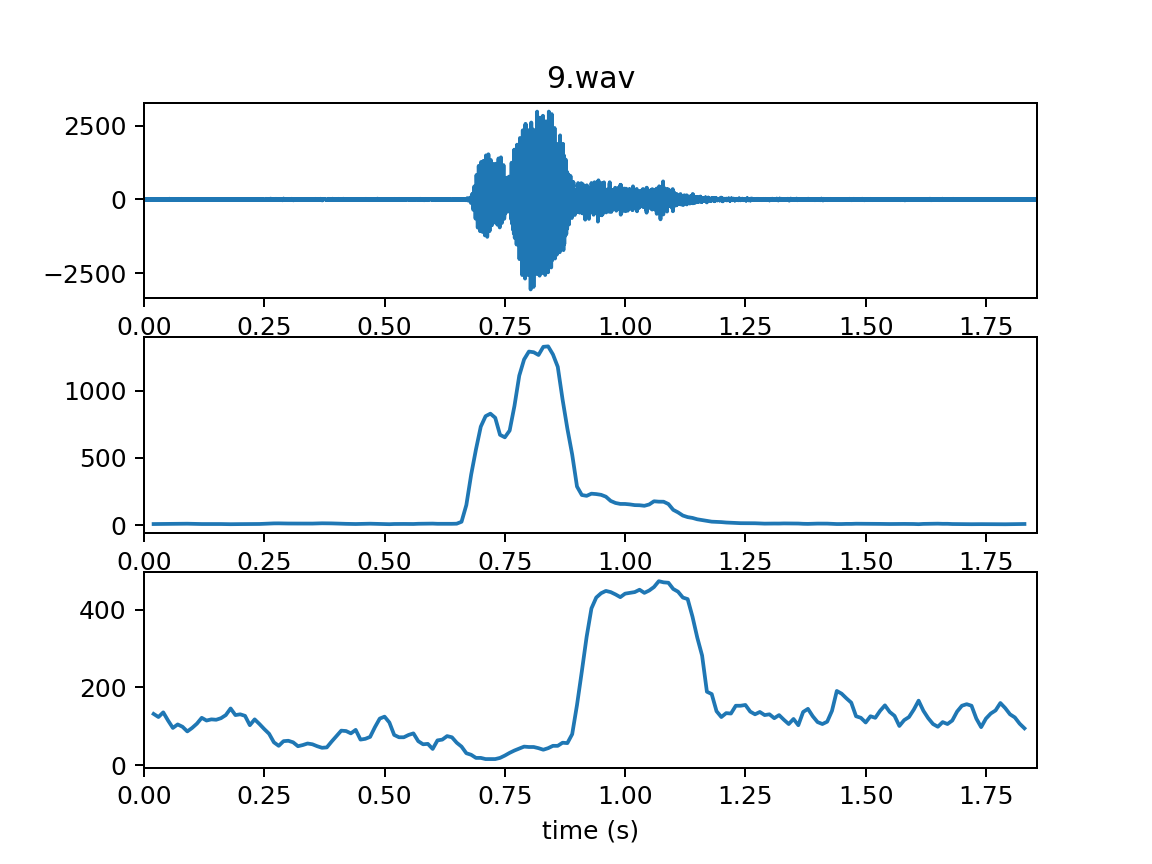

Text(0.5, 0, 'time (s)')

In [8]:
filename = "9.wav"
width = 0.04
overlap = 0.75

sample_rate, signal = wavfile.read(filename)
ns = len(signal)
t1 = np.arange(ns) / sample_rate
windows = windowing (signal, sample_rate, width, overlap)
nr = windows.shape[0]
t2 = np.arange(nr) * width * (1 - overlap) + width / 2
rms = root_mean_square(windows)
zc = zero_crossing(windows)

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t1, signal)
plt.xlim(0, np.max(t1))
plt.title(filename)
plt.subplot (3, 1, 2)
plt.plot(t2, rms)
plt.xlim(0, np.max(t1))
plt.subplot (3, 1, 3)
plt.plot(t2, zc)
plt.xlim(0, np.max(t1))
plt.xlabel("time (s)")

<span style="color:blue">
### Analyse du code :

On définit une largeur de fenêtre et un recouvrement pour appliquer la fonction de fenêtrage (windowing). En ouvrant l'enregistrement à analyser, on récupère la fréquence d'échantillonnage. 

Ensuite, on applique la fonction de fenêtrage.

On définit l'échelle de temps t1 comme étant le nombre de points du signal divisé par la fréquence d'échantillonnage :
T=N/Fe
où N est le nombre de points du signal et Fe est la fréquence d'échantillonnage.

nr est le nombre de fenêtres obtenues. t2 est l'échelle de temps définie pour l'energie.

Ensuite, on trace trois graphes :

1. Le signal en fonction de t1 pour voir l'amplitude en fonction du temps.
2. La valeur quadratique moyenne (RMS) en fonction du temps. La fonction root_mean_square calcule la valeur quadratique moyenne pour chaque fenêtre on obtient l'energie.
3. Le taux de passages par zéro (Zero Crossing Rate / ZCR) en fonction du temps. La fonction zero_crossing calcule le taux de passages par zéro pour chaque fenêtre.

### Interprétation :

#### Premier graphe :
Pour mieux comprendre, j'ai fait correspondre les variations d'amplitude aux parties prononcées. Ici, le mot "neuf" est divisé en trois parties : 
- Le "n" de 0,60 à 0,75 secondes,
- Le "eu" qui est le plus grand pic d'amplitude et correspond au milieu du mot,
- Les "frictions" à la fin correspondent au "f" de "neuf".
    
    
#### Deuxième graphe :
L'énergie du signal est tracée en fonction du temps. L'énergie est définie comme l'intégrale de notre signal au carré (d'où les valeurs positives). On retrouve la forme du signal avec un pic d'énergie libérée pendant la prononciation du "n" (consonne sonnante) et de la voyelle "eu". Cependant, on ne voit pas le "f" car il n'y a pas d'information concernant cette consonne fricative (énergie faible). C'est pourquoi on se réfère également au graphique suivant. + permet de detecter les silences (quand rien est prononcé amplitude nulle)

#### Troisième graphe :
Le taux de passages par zéro (ZCR). Pour la parole, le ZCR est faible pour les zones voisées et très élevé pour les zones non voisées. C'est pourquoi pour le "f" on observe un grand pic, et un ZCR faible pour la voyelle "eu". + remarque fait ressortir le bruit

### Conclusion :
Les deux principaux paramètres temporels pour analyser le signal sont le ZCR et l'énergie.

</span> 

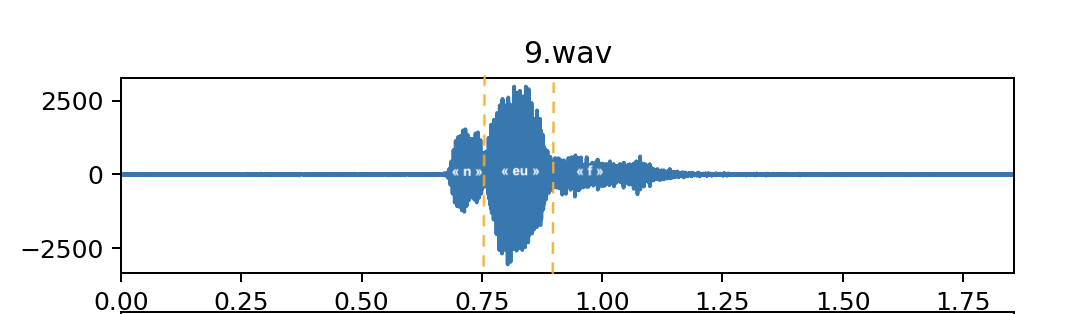

Avant de passer à la question suivante, essayez d'imaginer comment ces
caractéristiques temporelles pourraient servir à la détection des
frontières des mots dans un système de RAP.

<span style="color:blue">
Comme on a pu l'identifier, le RMS montre les pics d'énergie qui peuvent correspondre à la prononciation de consonnes occlusives et de voyelles (sons voisés) et permet de détecter les silences. En revanche, le ZCR met en évidence le bruit, les consonnes fricatives et les brusques variations. Les variations du ZCR sont significatives de l’alternance entre les sons voisés et non voisés, ce qui indique la présence de parole.

Pour la parole, le ZCR est faible pour les zones voisées et très élevé pour les zones non voisées. Étant donné que la parole est une suite de sons produits soit par des vibrations des cordes vocales (source quasi périodique de voisement), soit par une turbulence créée par l’air s’écoulant dans le conduit vocal ou lors du relâchement d’une occlusion de ce conduit (sources de bruit non voisées), on peut utiliser ces informations pour la segmentation.

Lorsqu'on couple l’énergie avec le ZCR, un taux de passage par zéro faible et une énergie forte sont synonymes d’un son voisé, tandis qu’un taux de passage par zéro élevé indique une zone non voisée. Grâce à ces caractéristiques temporelles, il est possible de détecter les frontières des mots en délimitant le début et la fin de chaque mot.
  
Pour vérifier, nous allons tester notre audio qui contient tous les mots prononcés dans le même fichier. On remarque bien que ça fonctionne : nous avons la délimitation entre chaque mot avec le spectre d'énergie où l'on voit bien les amplitudes nulles. Cependant, je pense que pour voir vraiment si cela fonctionne, ce n'est pas un bon exemple car la prononciation est déjà saccadée. Il faudrait prendre une phrase fluide. Par conséquent, j'ai essayé avec la phrase "Emmanuel est là-bas" et j'ai l'impression de pouvoir voir dans le graphe d'énergie la délimitation entre "Emmanuel" et "est là-bas" avec les variations des amplitudes (qui décroissent entre chaque mot).

Avec le ZCR, on voit bien que le début et la fin où il y a le silence ou le bruit sont amplifiés. Donc, on peut conclure qu'à "là-bas", il y a peut-être rien qui se prononce.
</span> 

<IPython.core.display.Javascript object>


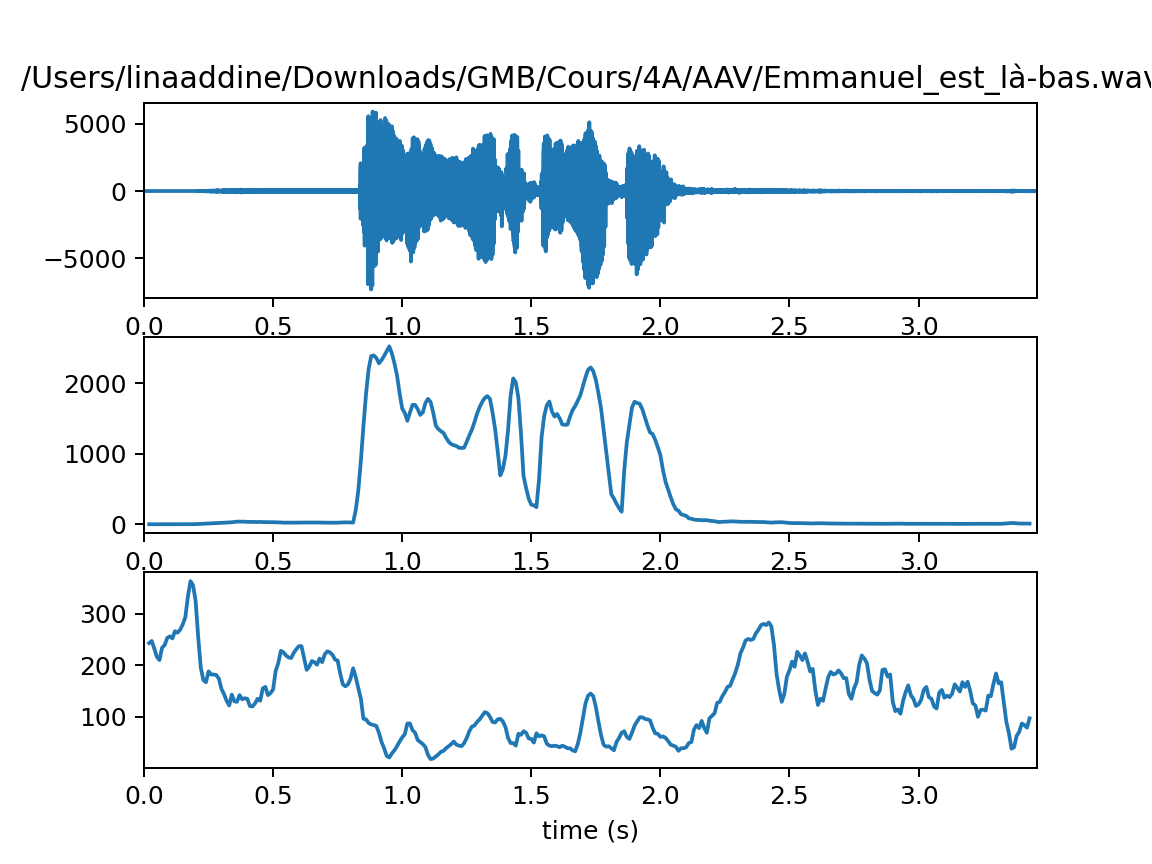

Text(0.5, 0, 'time (s)')

In [10]:
filename = "/Users/khadidja/Downloads/GMB/Cours/4A/AAV/Emmanuel_est_là-bas.wav"
width = 0.04
overlap = 0.75

sample_rate, signal = wavfile.read(filename)
ns = len(signal)
t1 = np.arange(ns) / sample_rate
windows = windowing (signal, sample_rate, width, overlap)
nr = windows.shape[0]
t2 = np.arange(nr) * width * (1 - overlap) + width / 2
rms = root_mean_square(windows)
zc = zero_crossing(windows)

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t1, signal)
plt.xlim(0, np.max(t1))
plt.title(filename)
plt.subplot (3, 1, 2)
plt.plot(t2, rms)
plt.xlim(0, np.max(t1))
plt.subplot (3, 1, 3)
plt.plot(t2, zc)
plt.xlim(0, np.max(t1))
plt.xlabel("time (s)")

## V. Ajustement de l'algorithme de détection
Vous allez maintenant
ajuster les paramètres de la fonction de détection de début/fin de mot pour
les signaux que vous avez enregistrés.  Cet algorithme est très simple.  Il
considère comme partie d'un mot toute région où l'énergie ou les passages
par zéro dépassent certains seuils (*trms* et *tzc=*,
respectivement).  Les régions où l'énergie et les passages par zéro sont, à
la fois, inférieurs aux seuils pour une durée maximale (*tsmax*) sont
considérées comme des silences à l'intérieur des mots.  La durée minimale
d'un mot est donnée par *twmin*.  La figure ci-dessous illustre le
principe de l'algorithme, les frontières détectées du mot étant en rouge.



In [16]:
def endpoint_detection(filename, trms, tzc, twmin, tsmax, offset=0):
    sample_rate, signal = wavfile.read(filename)
    width = 0.04
    overlap = 0.75
    lag = (1 - overlap) * width
    ns = len(signal)
    t1 = np.arange(ns) / sample_rate
    windows = windowing (signal + offset, sample_rate, width, overlap)
    nr = windows.shape[0]
    t2 = np.arange(nr) * lag + width / 2
    rms = root_mean_square(windows)
    zc = zero_crossing(windows)

    has_signal = (rms > trms) + (zc > tzc)

    state = 0
    points = []

    for i in range(nr):
        if state == 0:
            if has_signal[i]:
                state = 1
                start_word = i
        elif state == 1:
            if not has_signal[i]:
                state = 2
                start_silence = i
            else:
                if i == nr:
                    points.append([start_word, i]);
        else:
            if not has_signal[i]:
                if i == nr-1 or (i - start_silence) * lag > tsmax:
                    if (start_silence - start_word) * lag > twmin:
                        points.append([start_word, start_silence])
                    state = 0
            else:
                state = 1

    points = width / 2 + np.array(points) * lag

    plt.figure(figsize=(9, 6))
    tlim = [0, max(t1)]
    plt.subplot(3, 1, 1)
    plt.plot(t1, signal, "b", label="signal")
    plt.title(filename)
    plt.xlim(0, np.max(t1))
    ylim = plt.ylim()

    for i in range(points.shape[0]):
        if i > 0:
            plt.plot([points[i,0], points[i, 0]], ylim, "r")
        else:
            plt.plot([points[i,0], points[i, 0]], ylim, "r", label="endpoints")
        plt.plot([points[i,1], points[i, 1]], ylim, "r")
    plt.legend(loc="upper right")
    plt.ylim(ylim)

    plt.subplot(3, 1, 2)
    plt.plot(t2, rms, "b", label="RMS")
    plt.plot(tlim, [trms, trms], "r", label="threshold")
    plt.xlim(tlim)
    plt.legend(loc="upper right")

    plt.subplot(3, 1, 3)
    plt.plot(t2, zc, "b", label="zero crossing")
    plt.plot(tlim, [tzc, tzc], "r", label="threshold")
    plt.xlim(tlim)
    plt.legend(loc="upper right")
    plt.xlabel("time (s)")
    
    return points

1. Essayez-la avec vos signaux et trouvez les valeurs des paramètres qui permettent la détection correcte du début et de la fin de chaque mot.

<IPython.core.display.Javascript object>


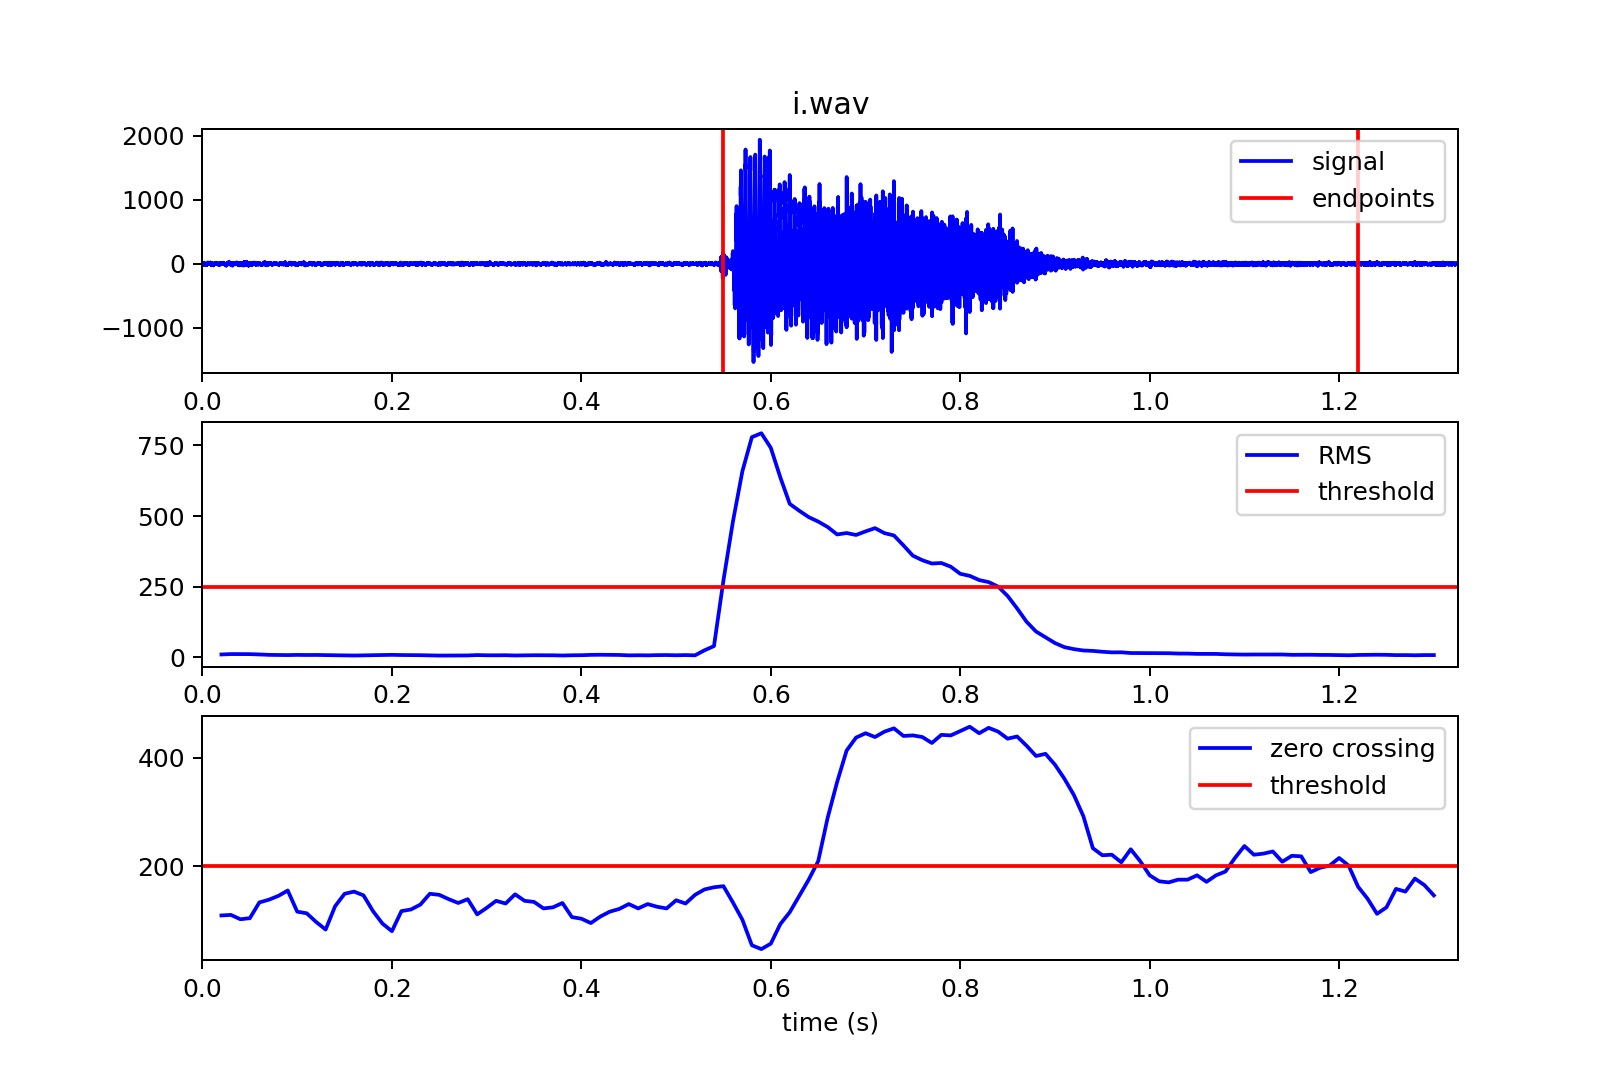

<IPython.core.display.Javascript object>


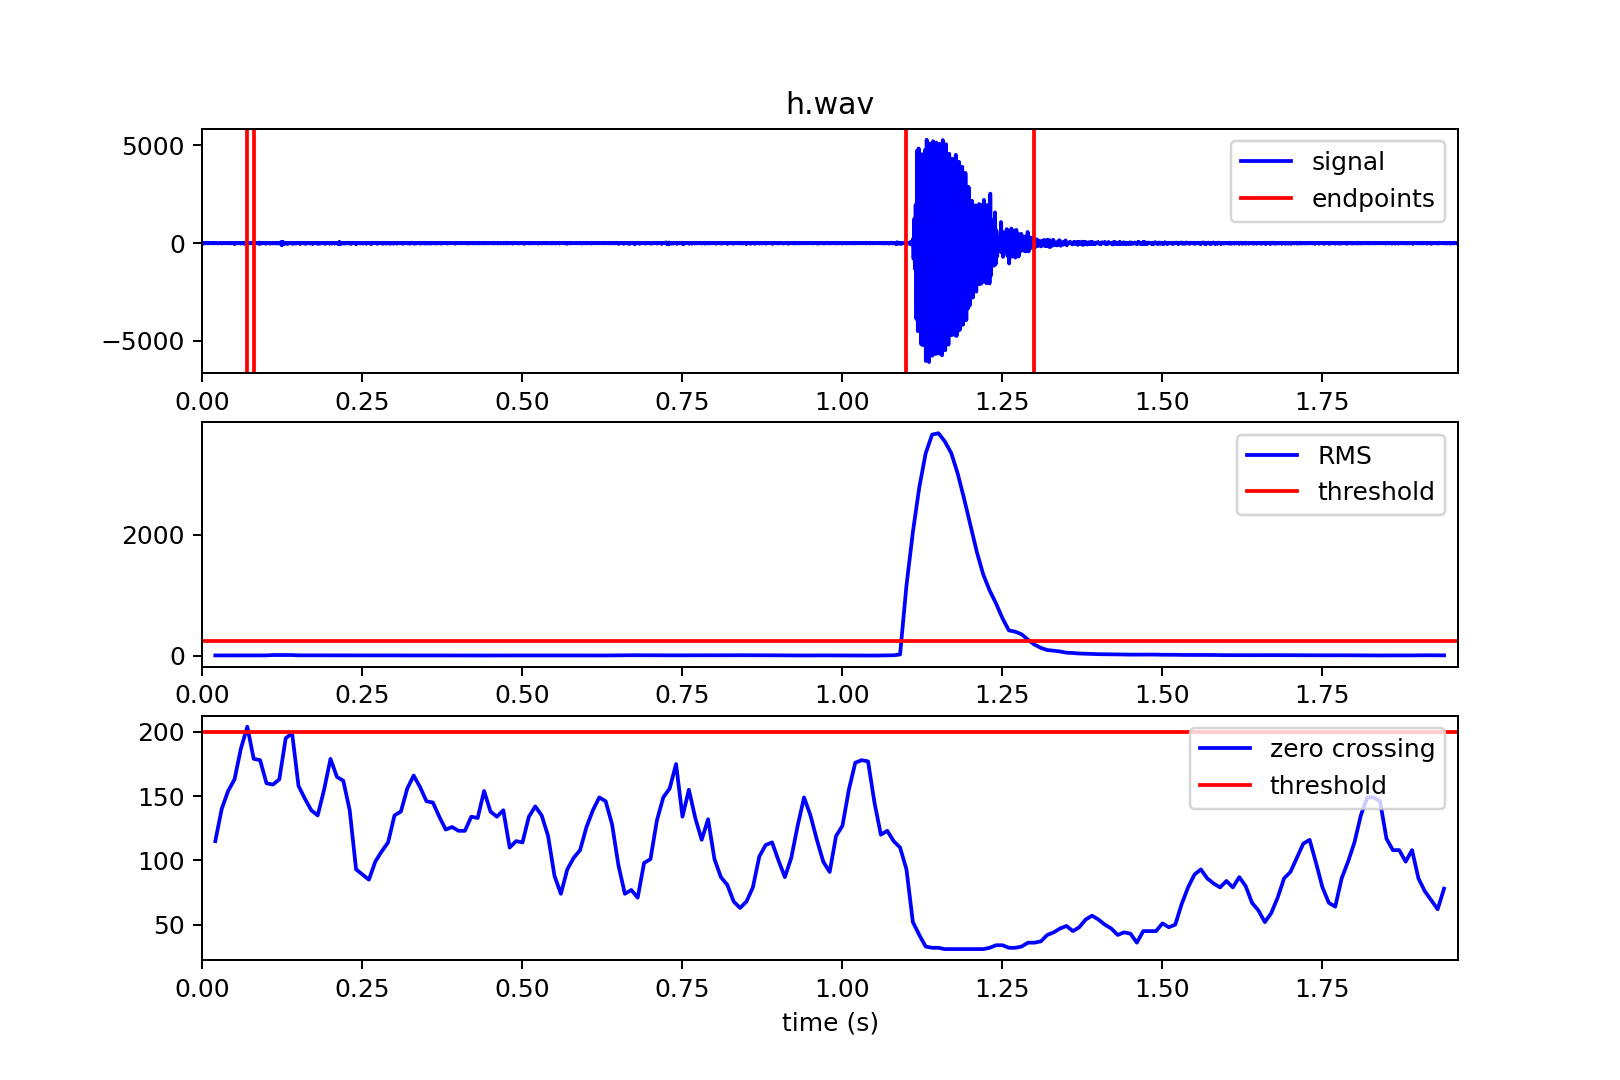

<IPython.core.display.Javascript object>


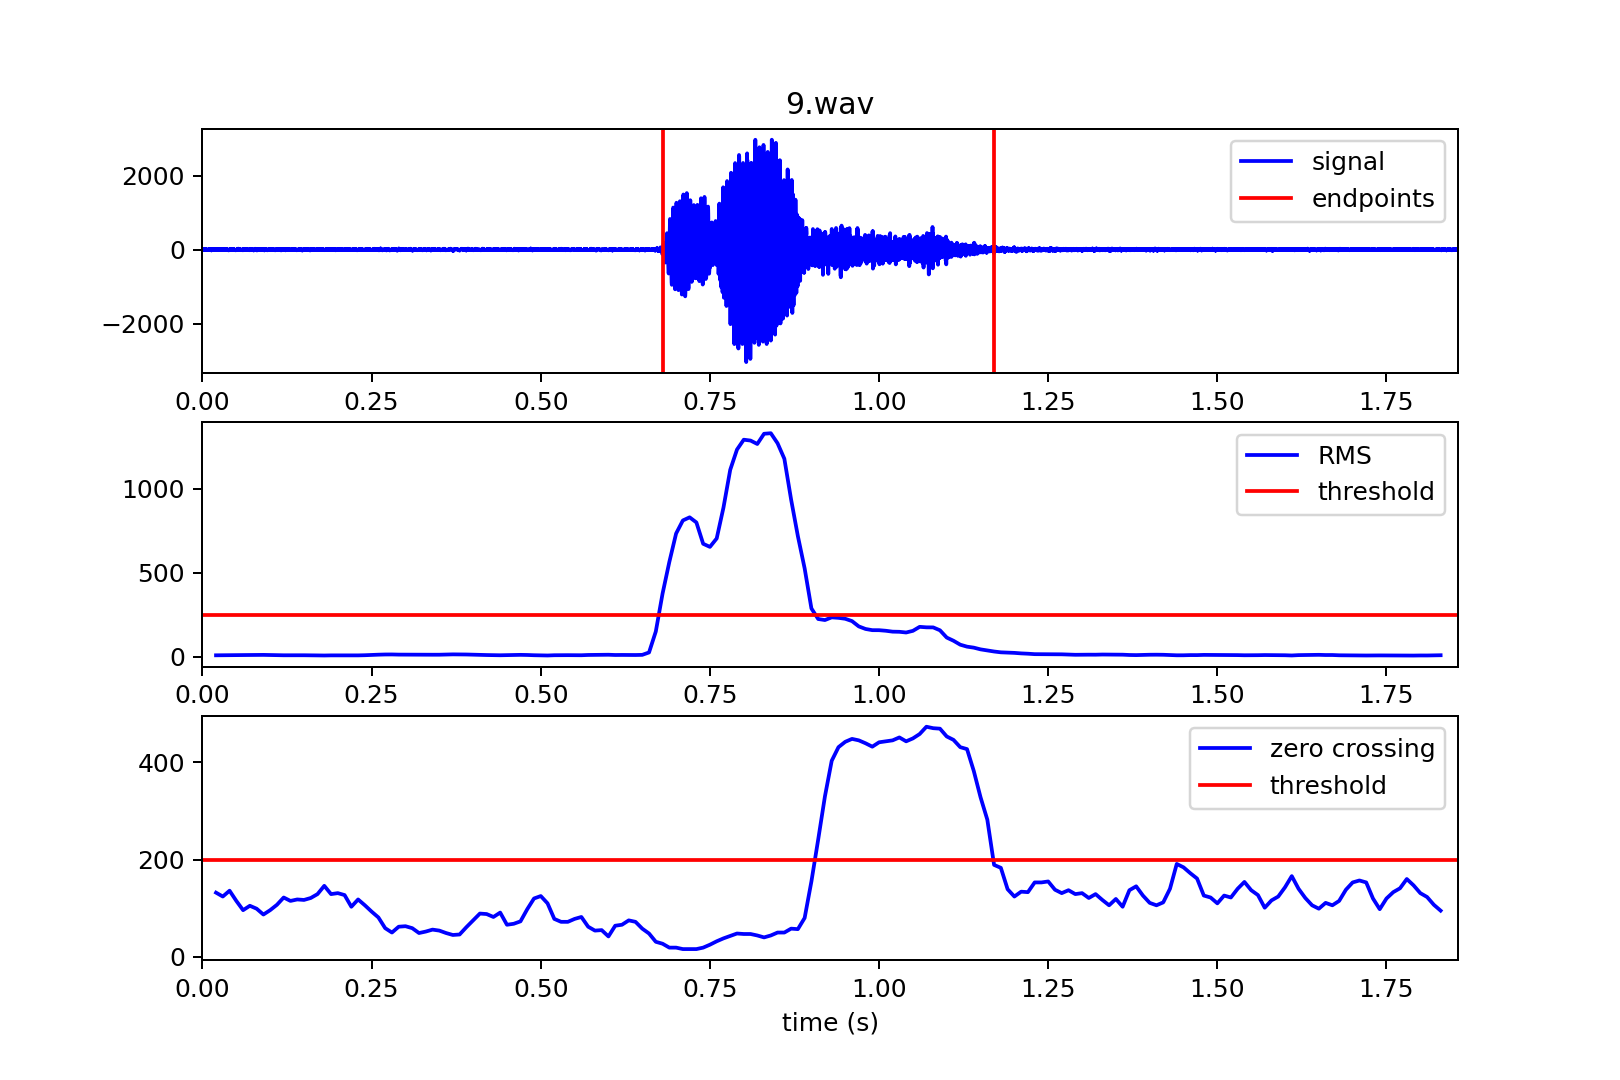

<IPython.core.display.Javascript object>


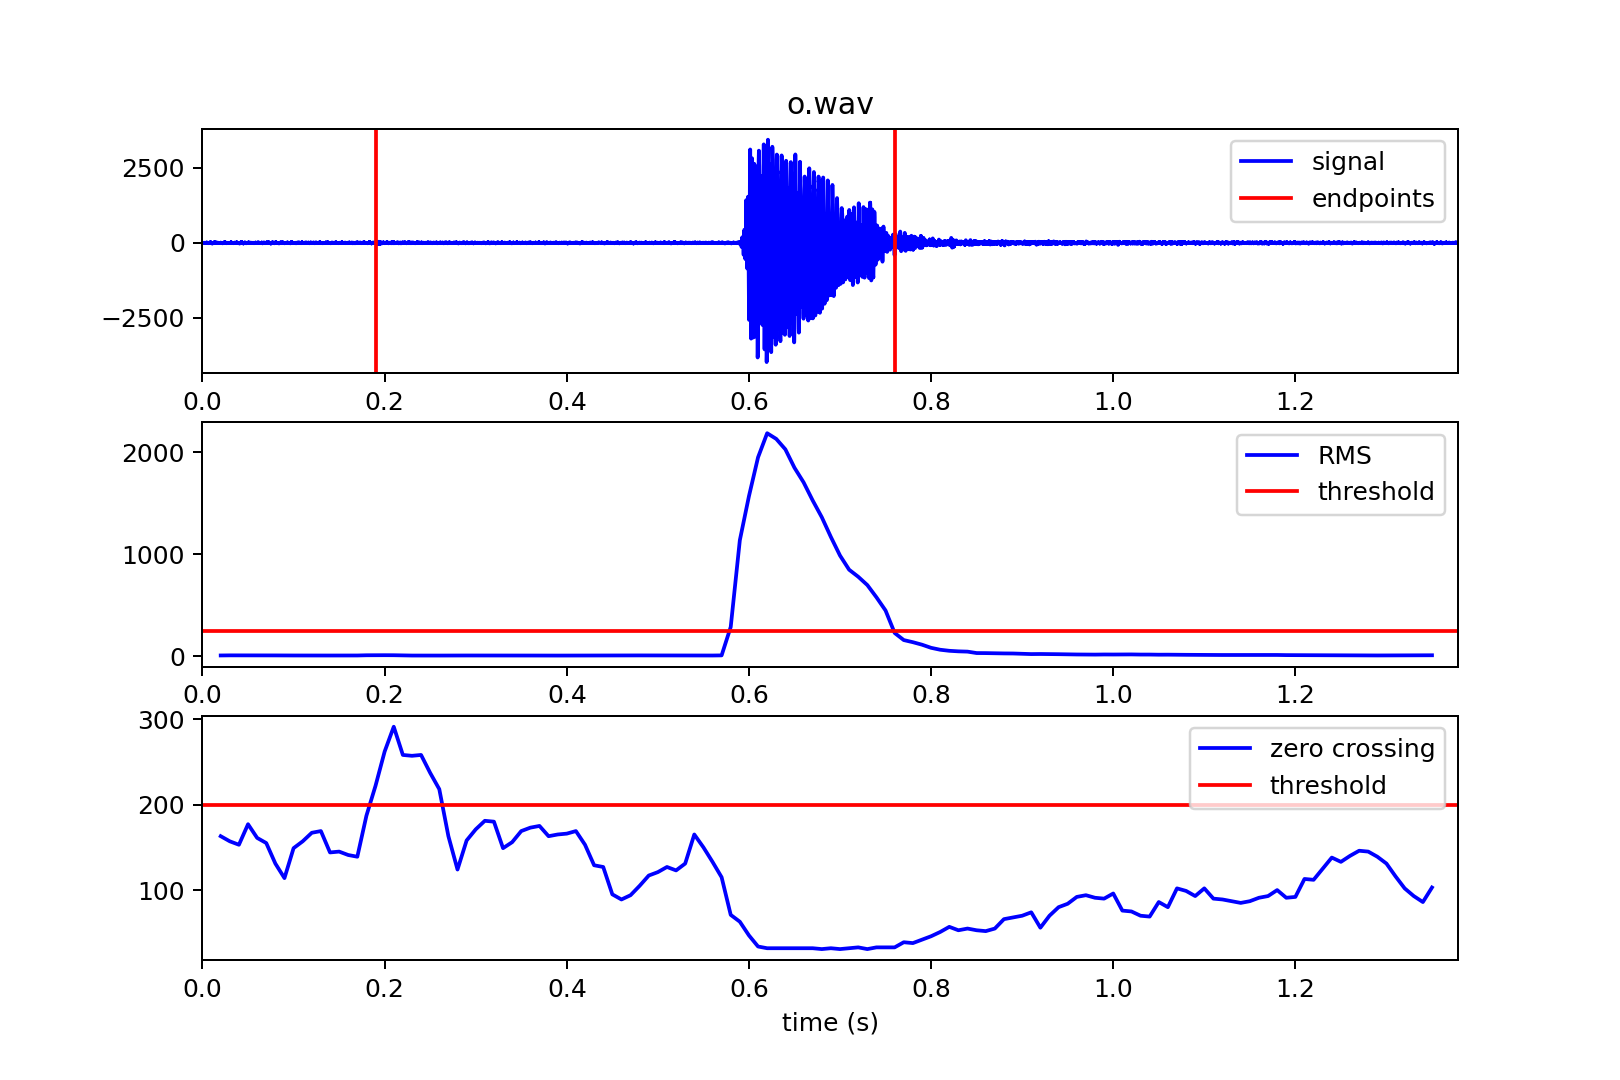

<IPython.core.display.Javascript object>


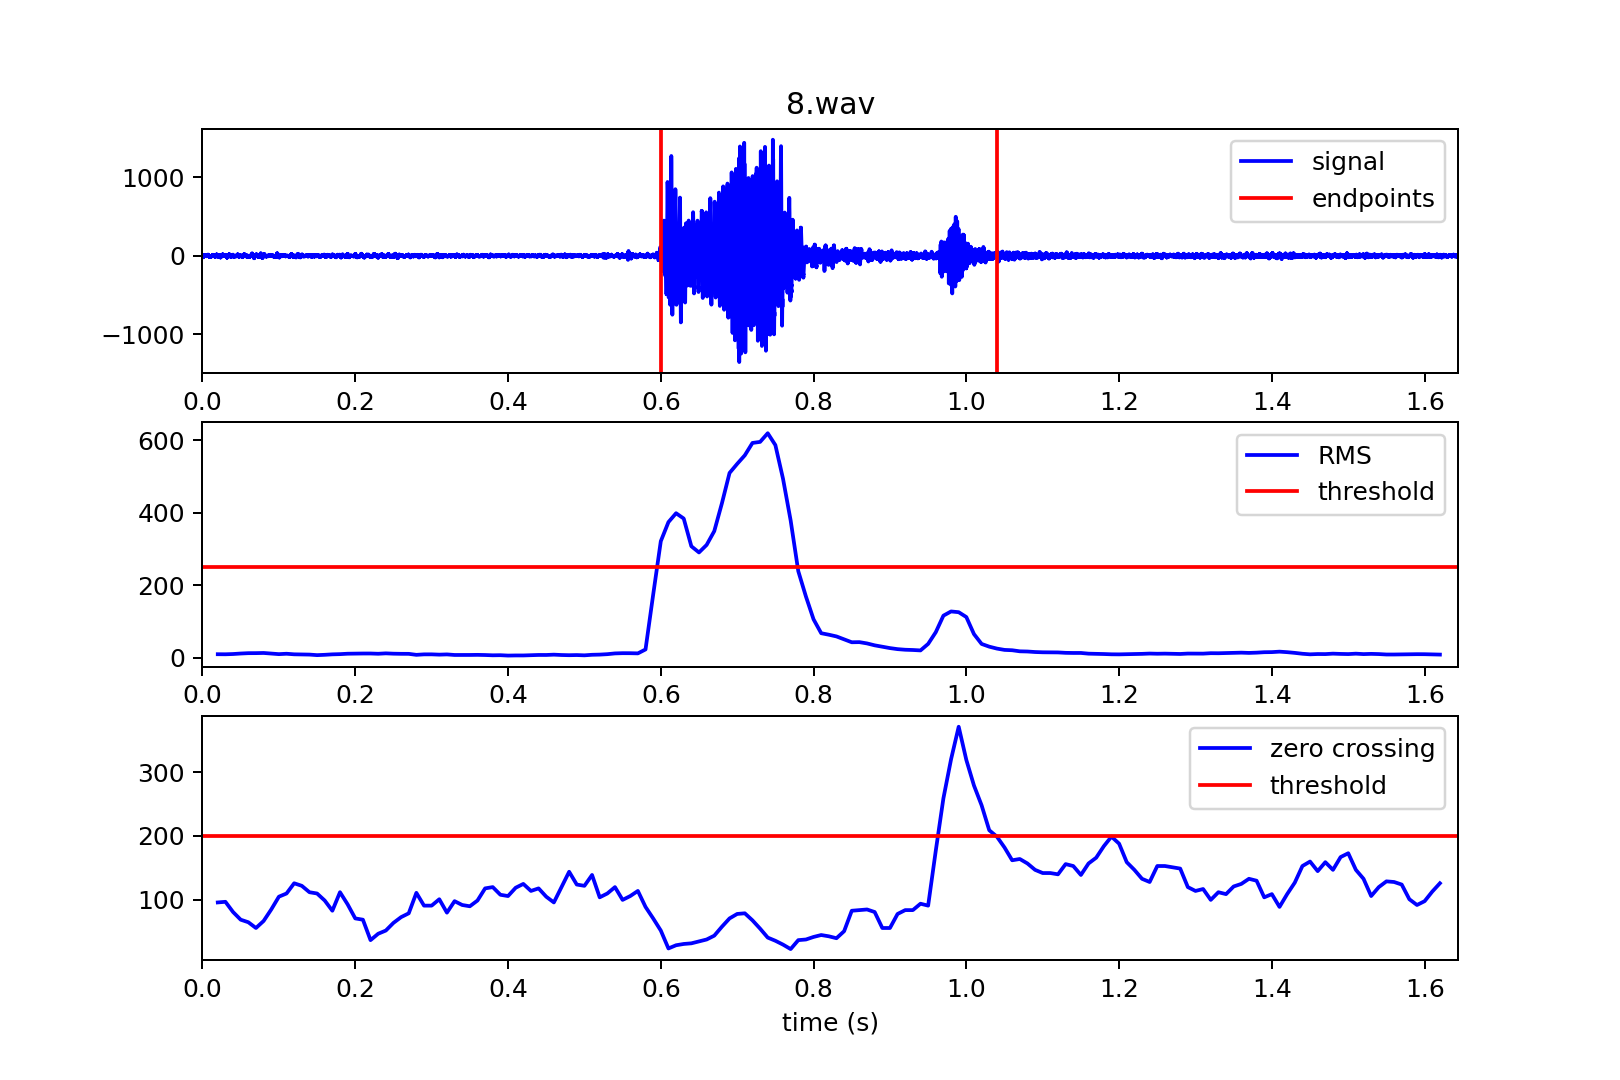

<IPython.core.display.Javascript object>


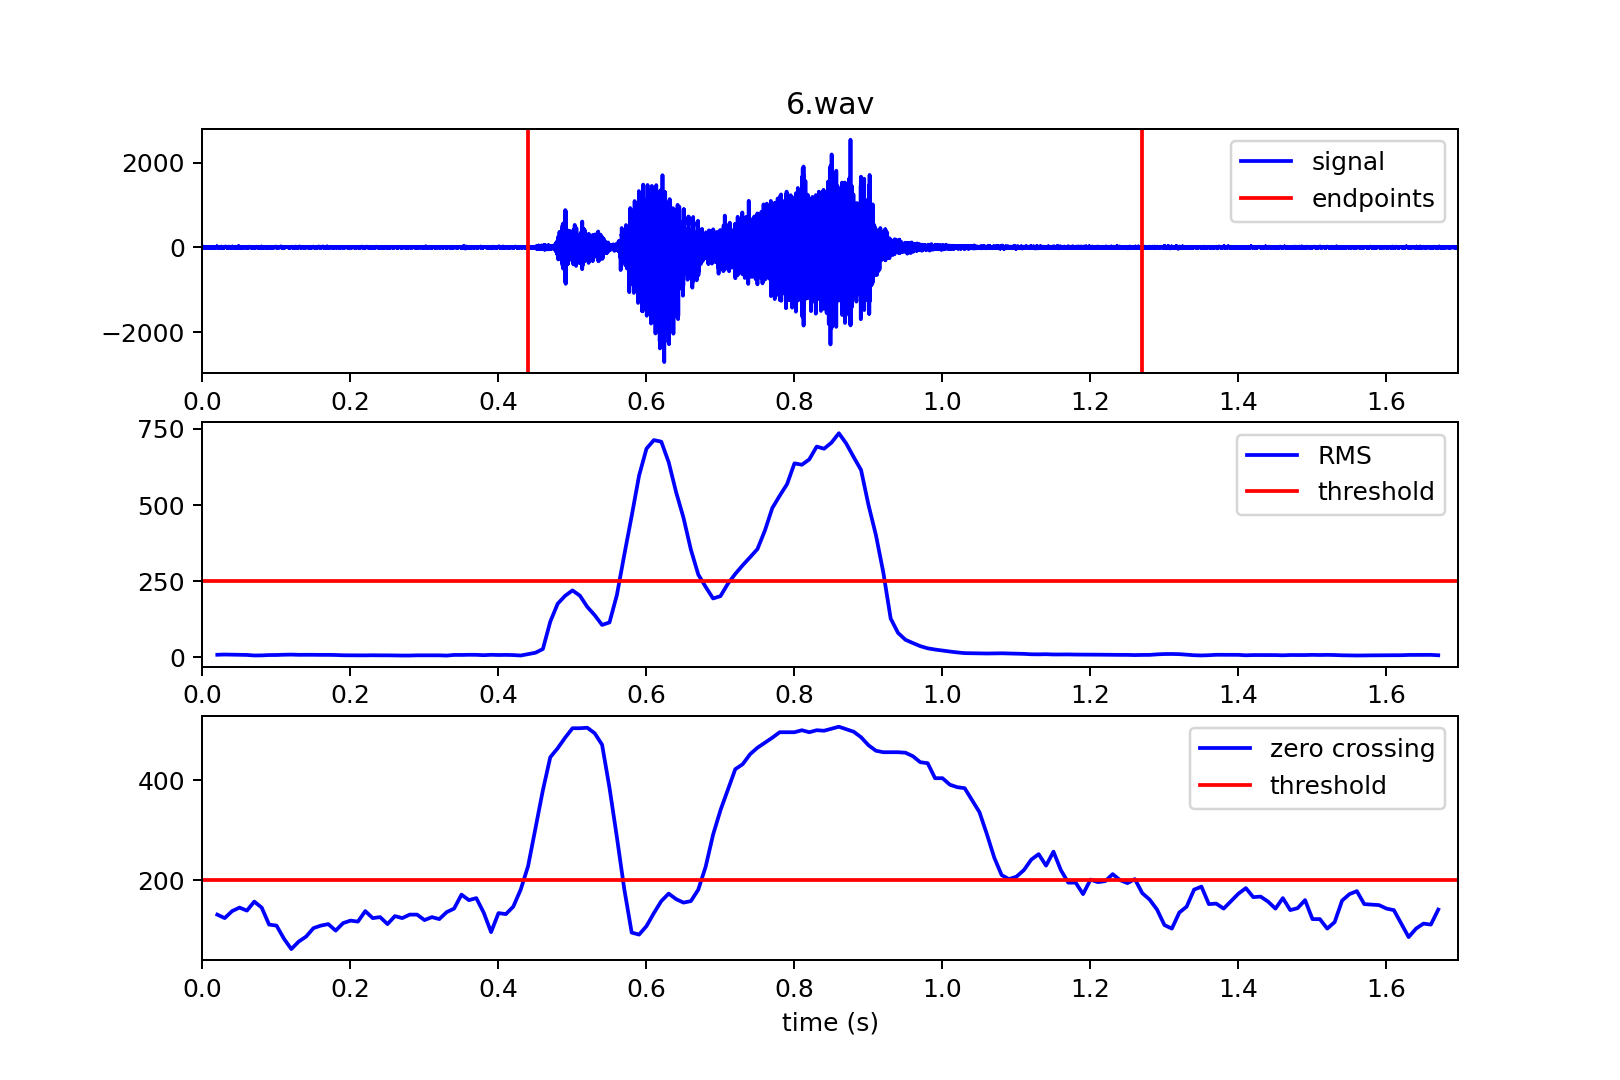

<IPython.core.display.Javascript object>


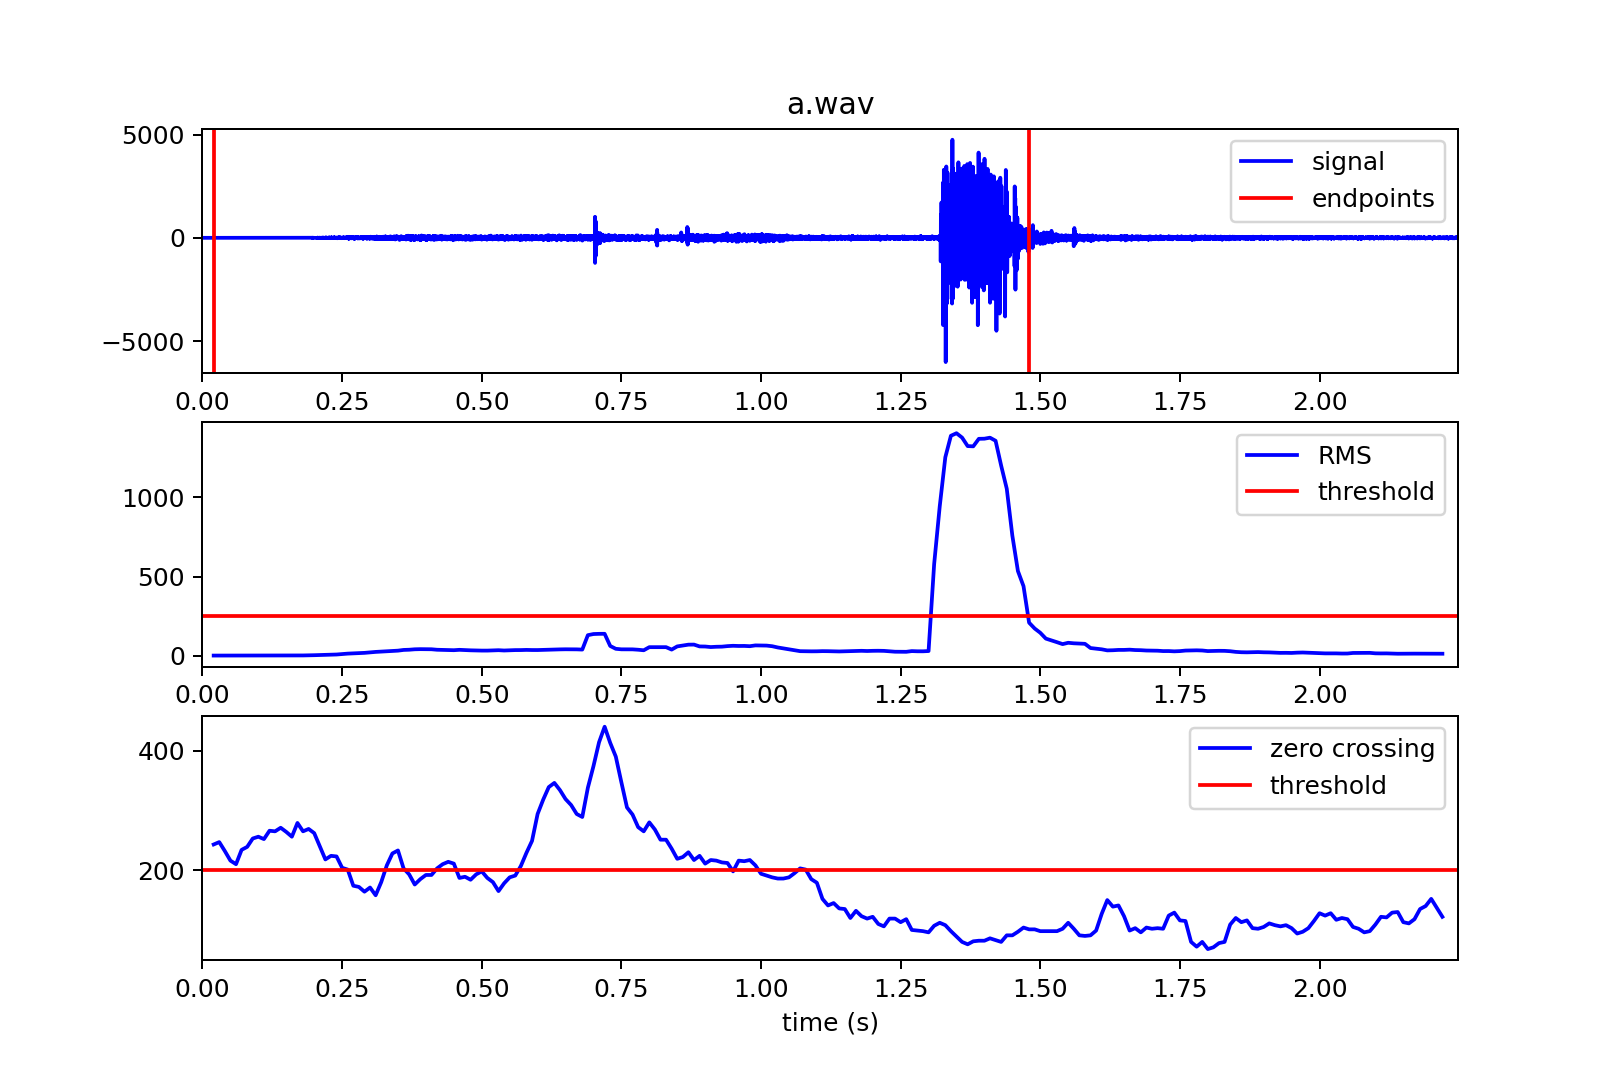

<IPython.core.display.Javascript object>


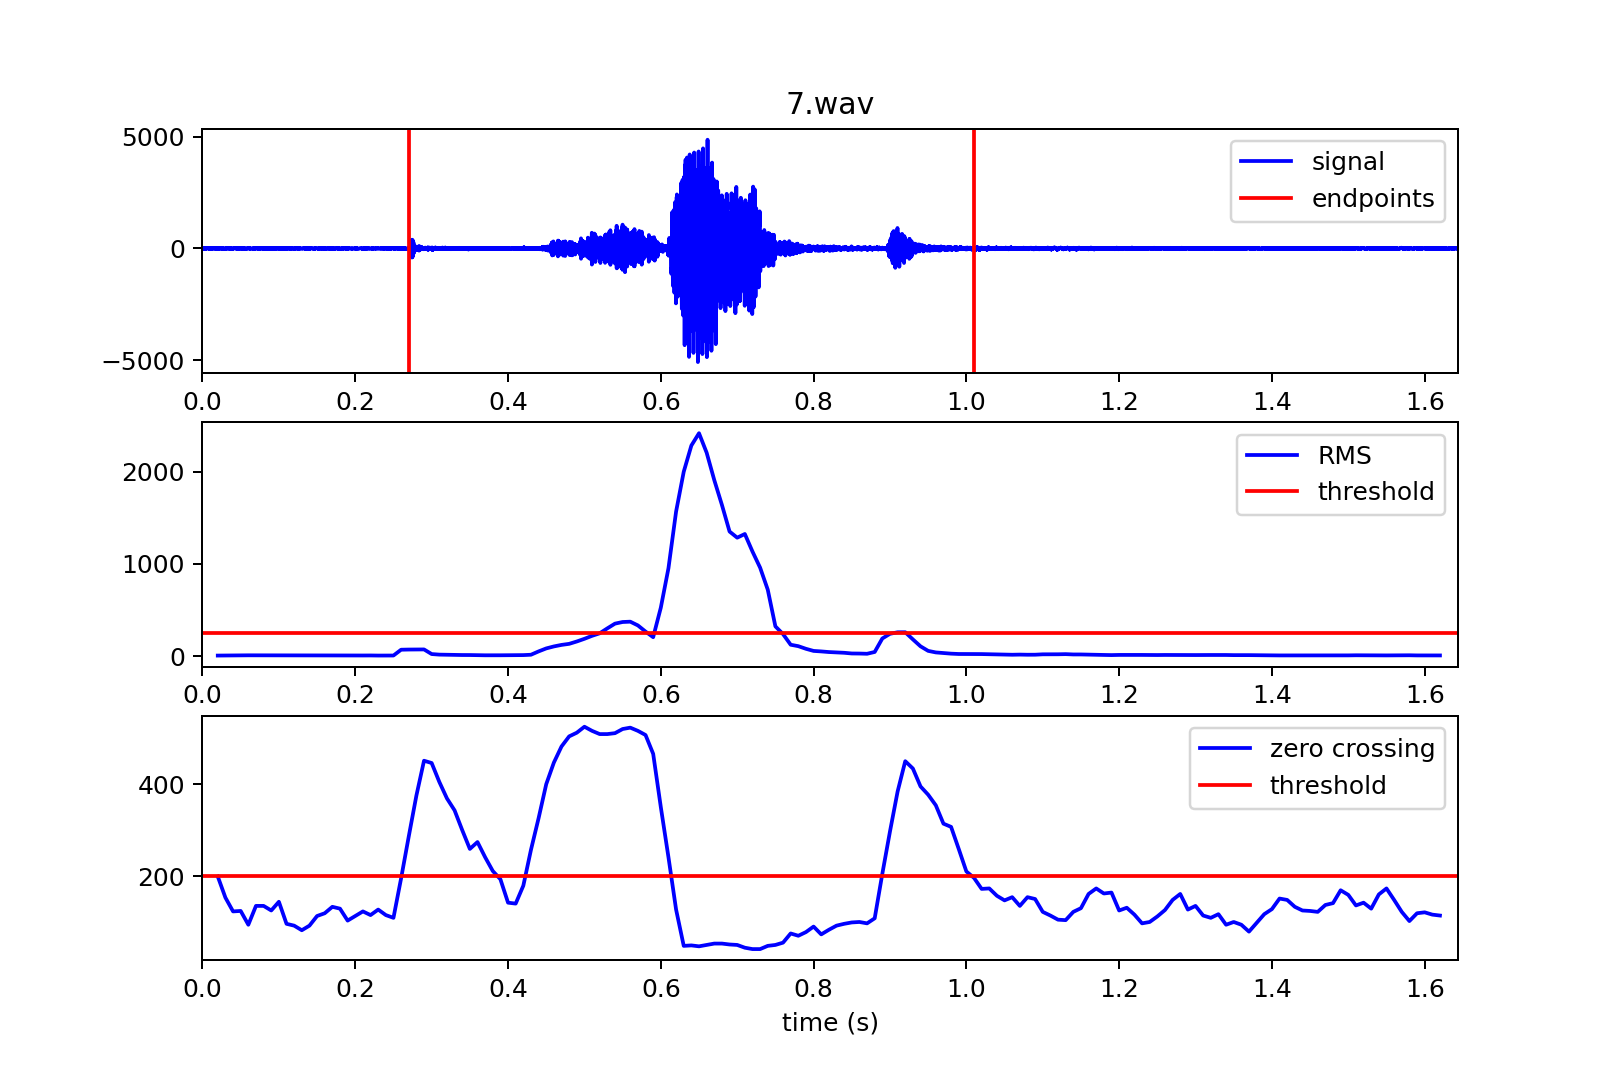

<IPython.core.display.Javascript object>


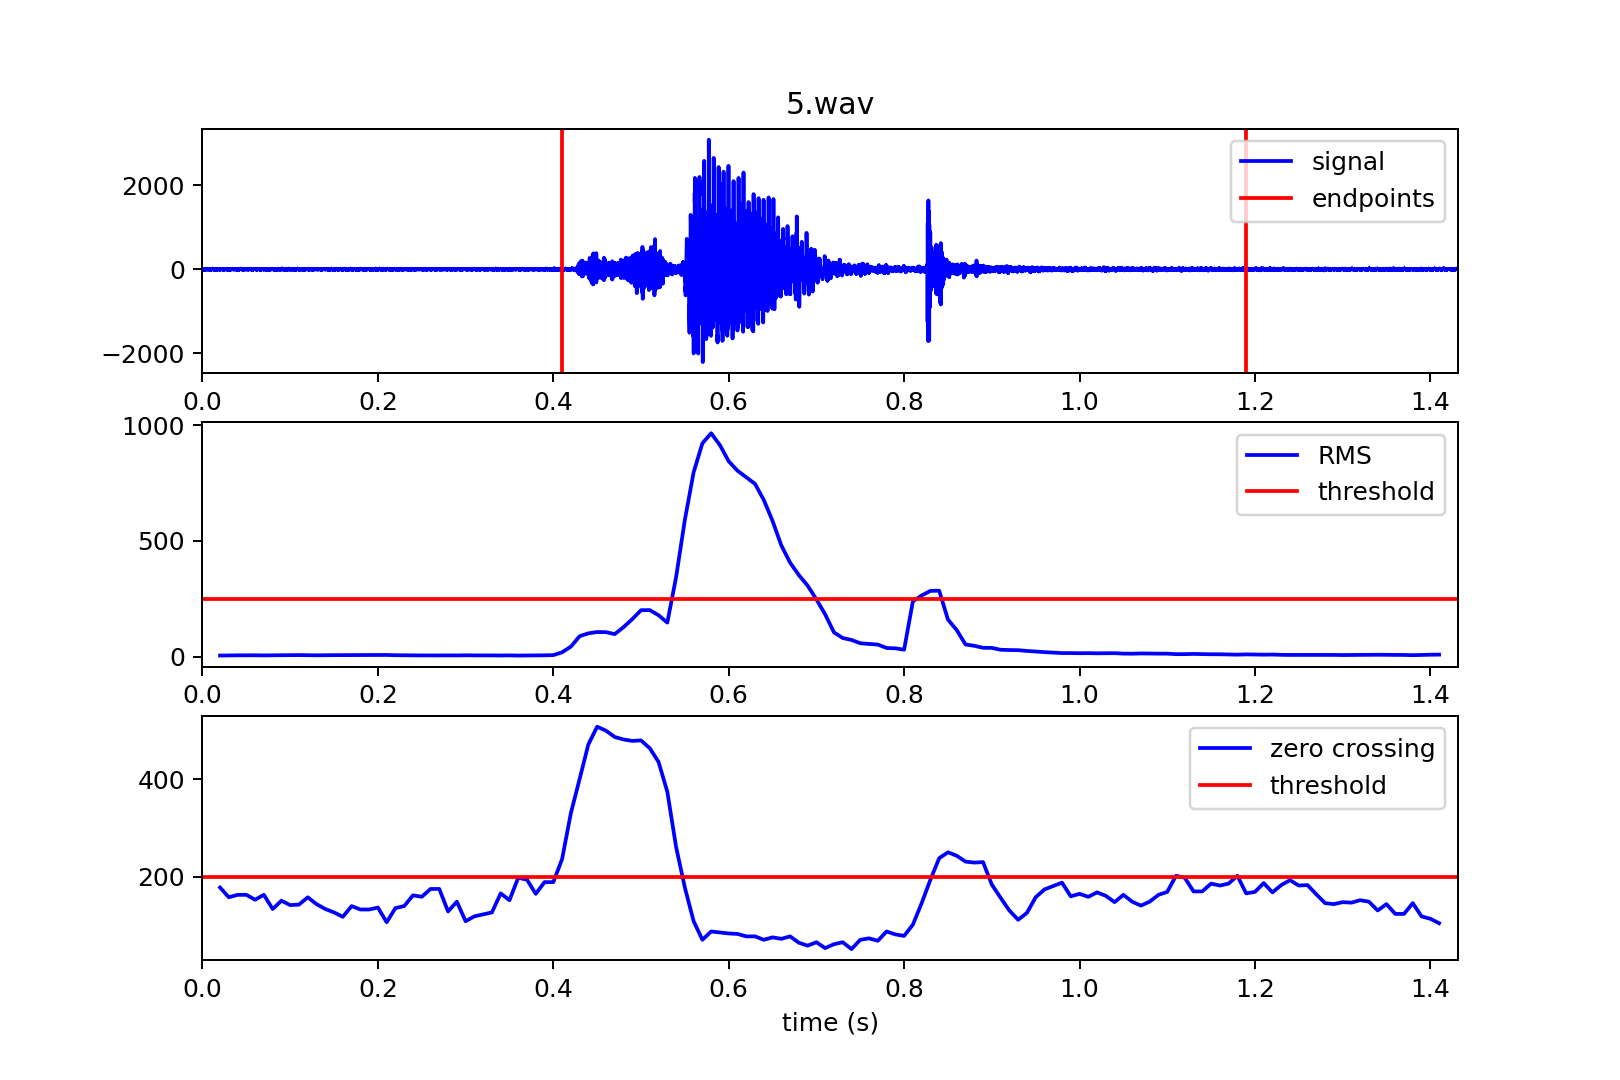

<IPython.core.display.Javascript object>


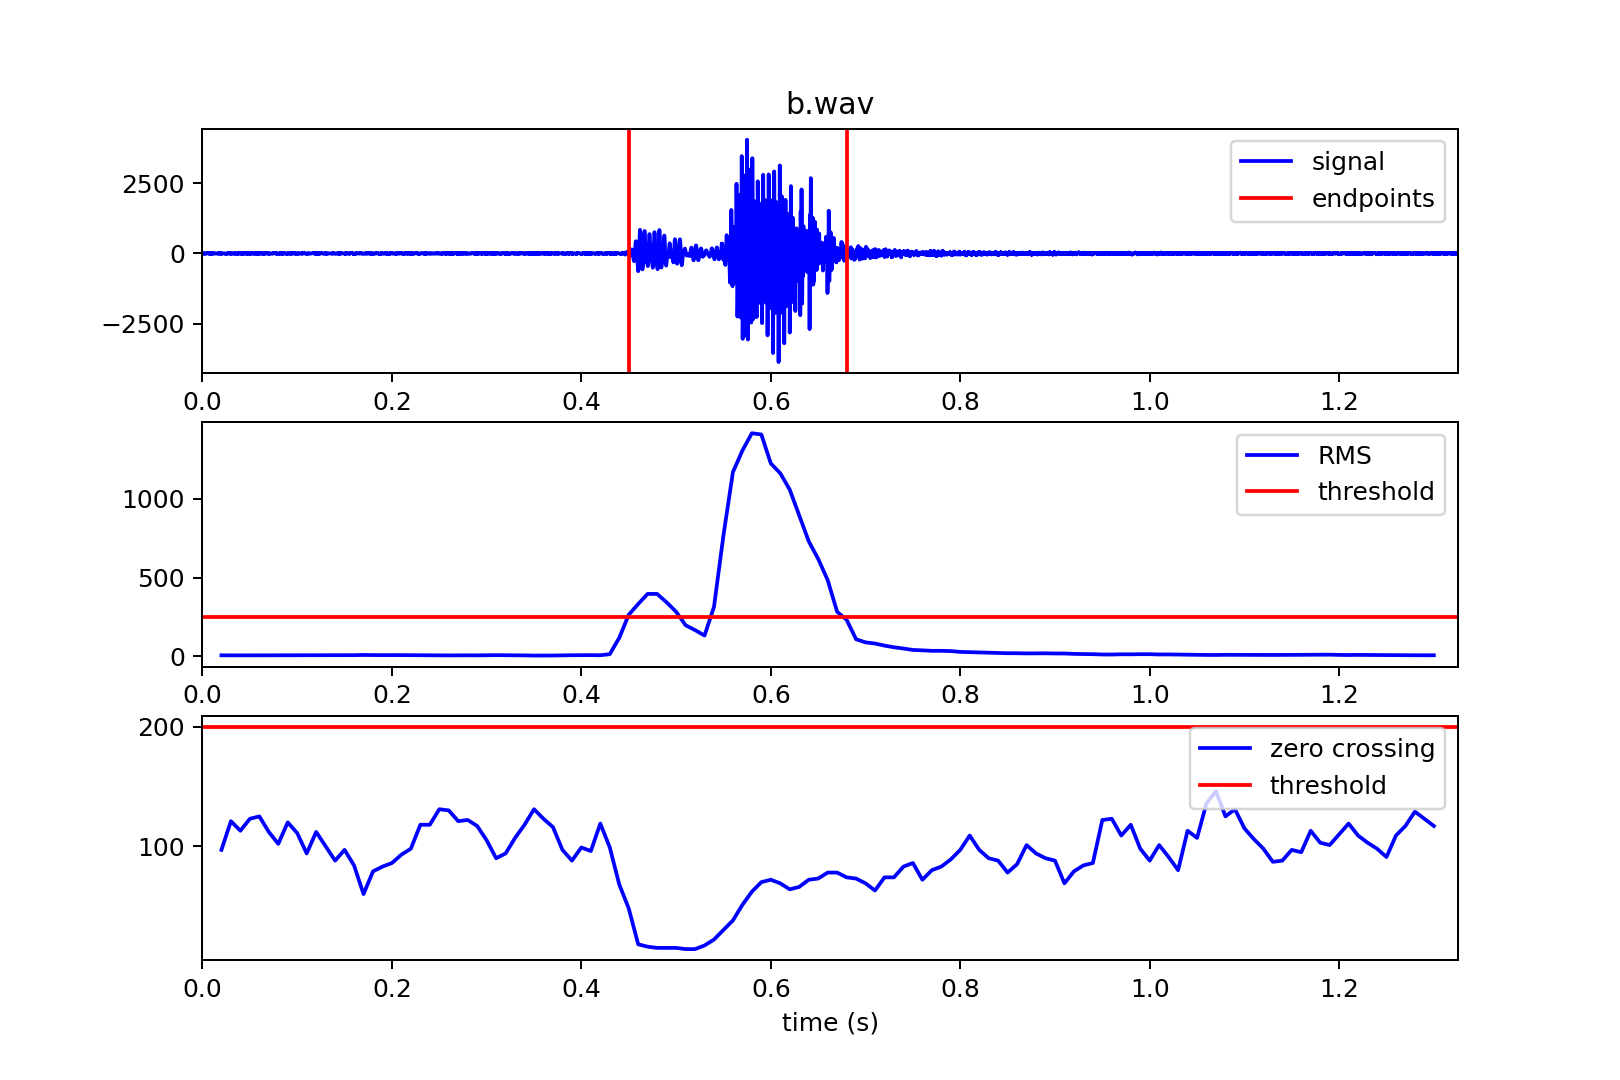

<IPython.core.display.Javascript object>


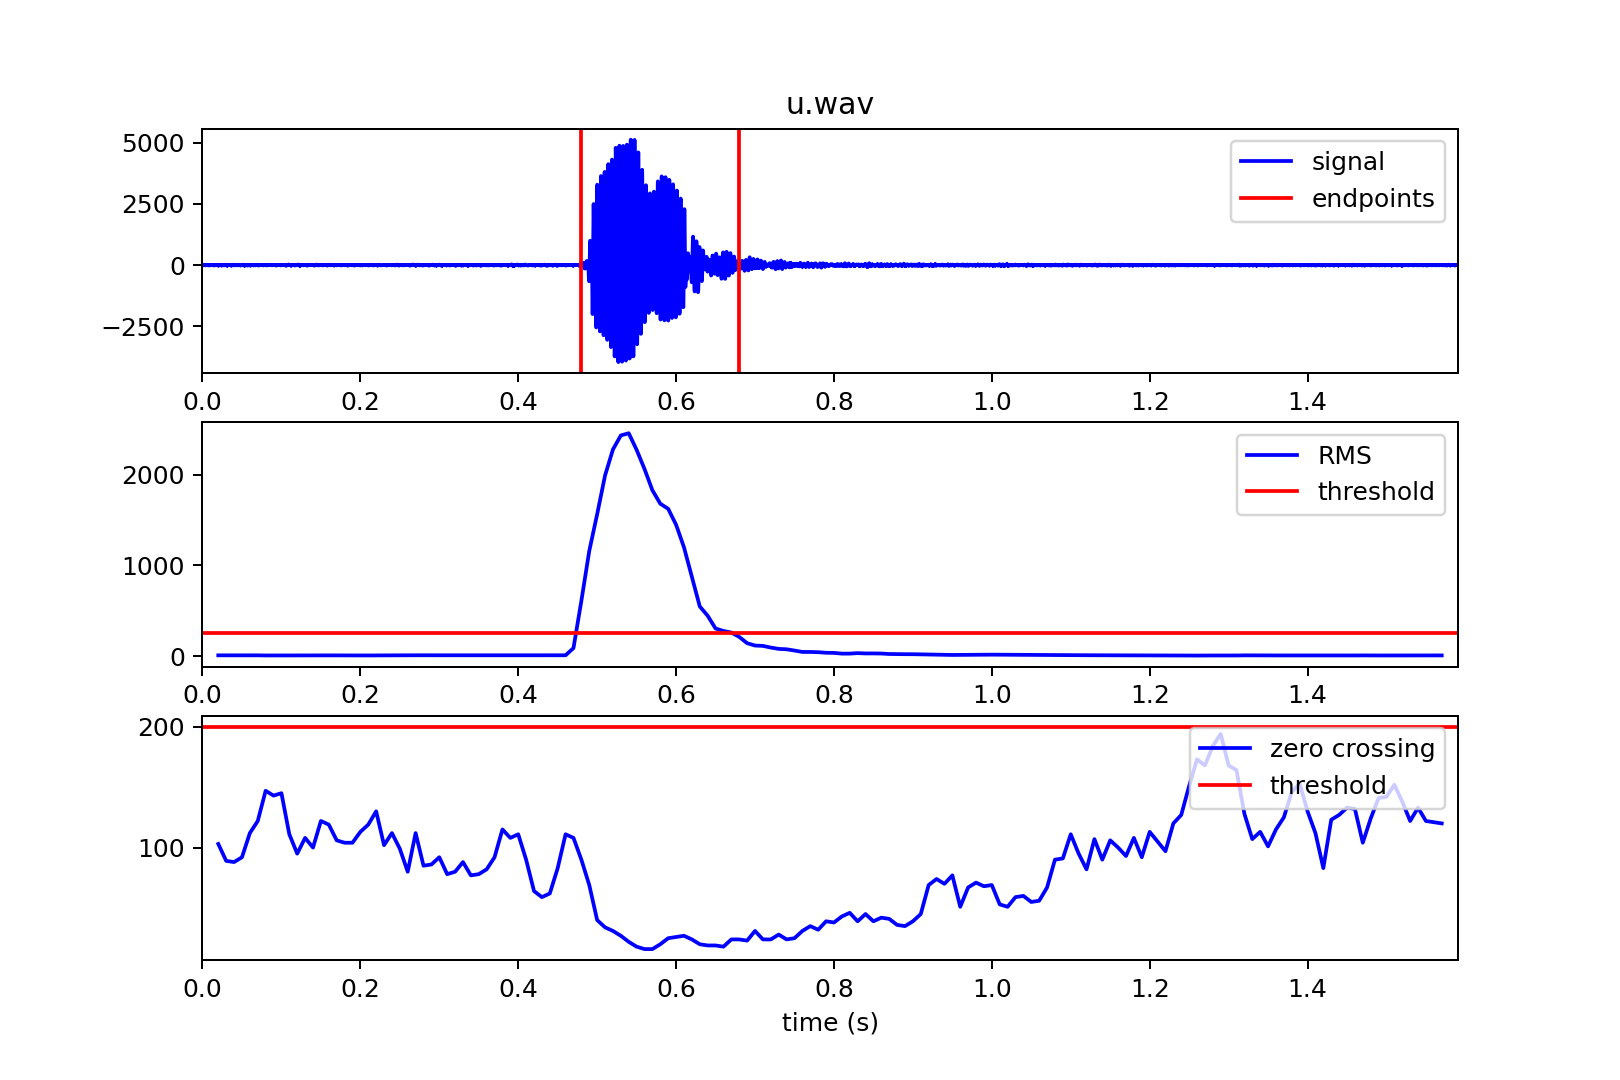

<IPython.core.display.Javascript object>


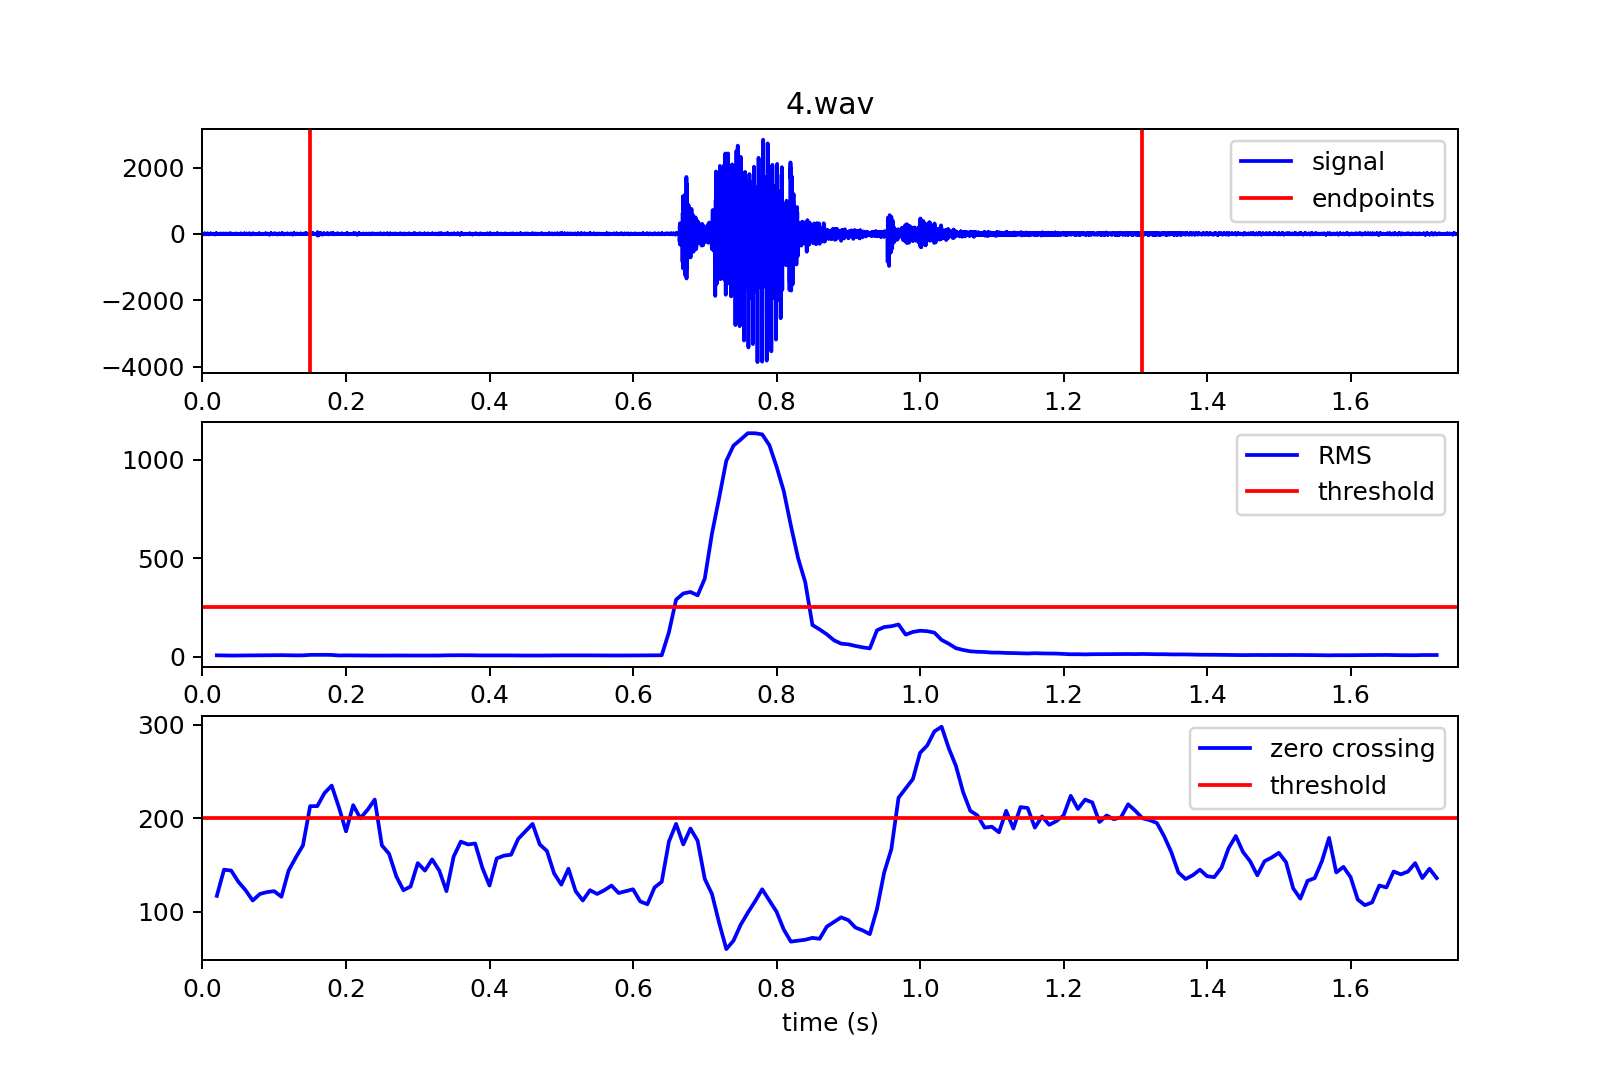

<IPython.core.display.Javascript object>


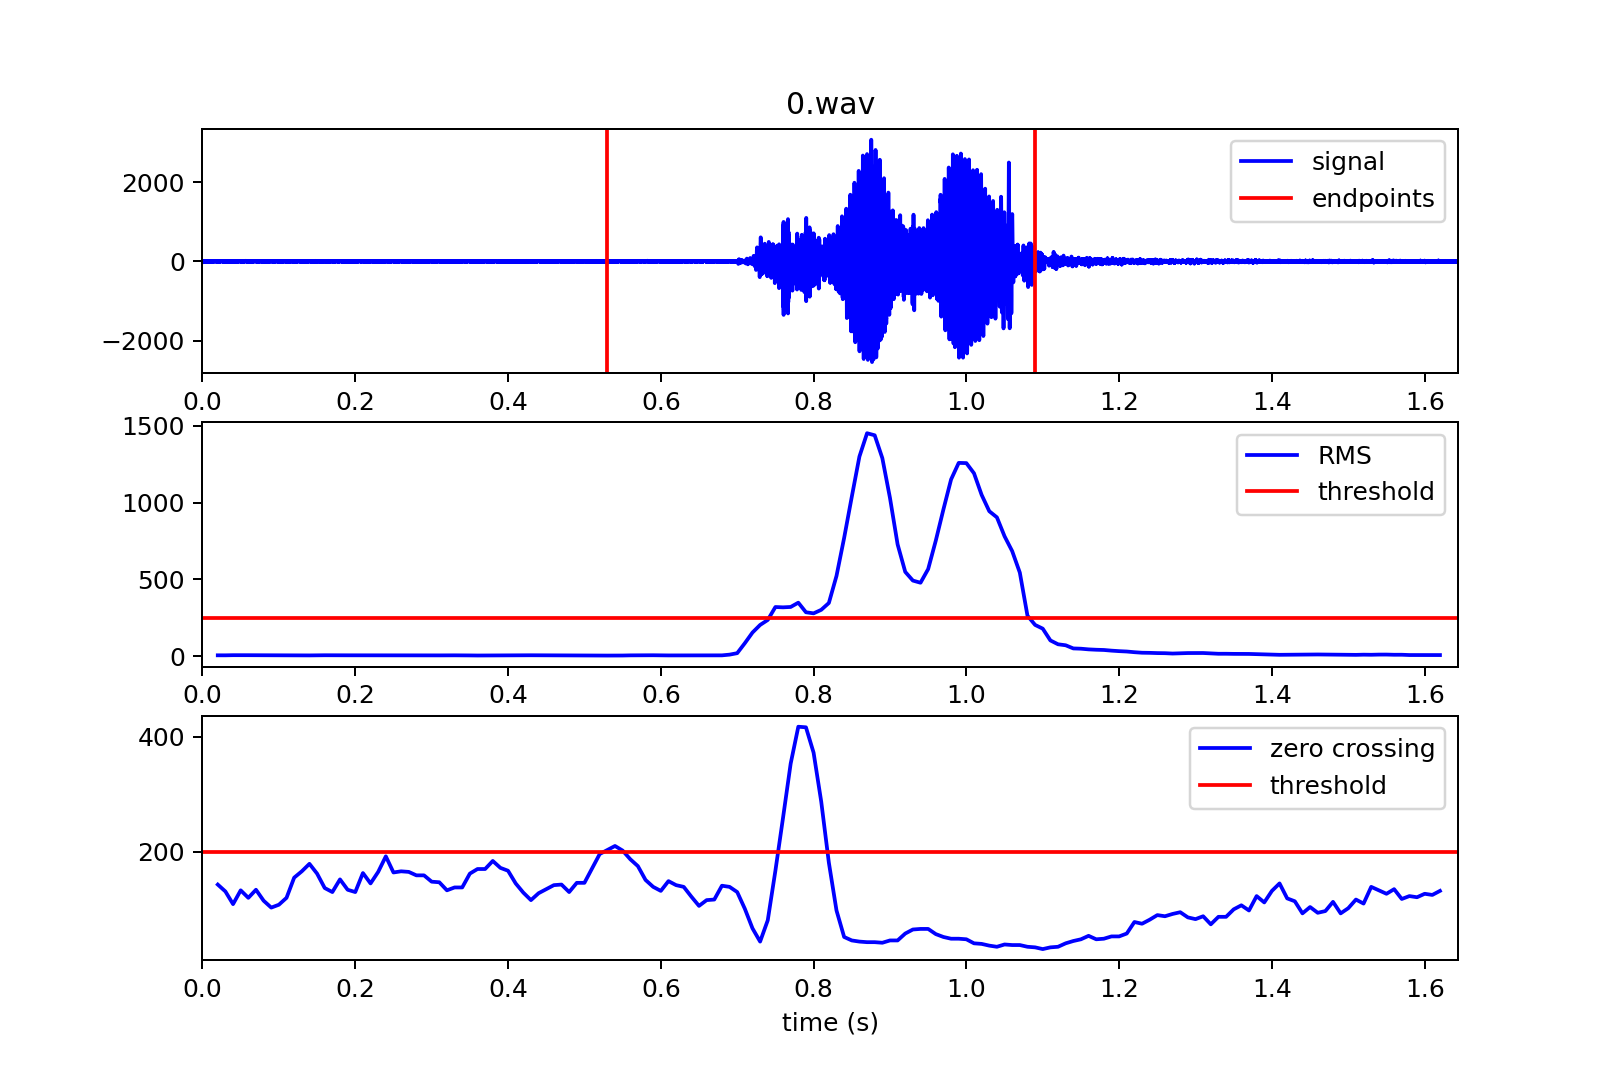

<IPython.core.display.Javascript object>


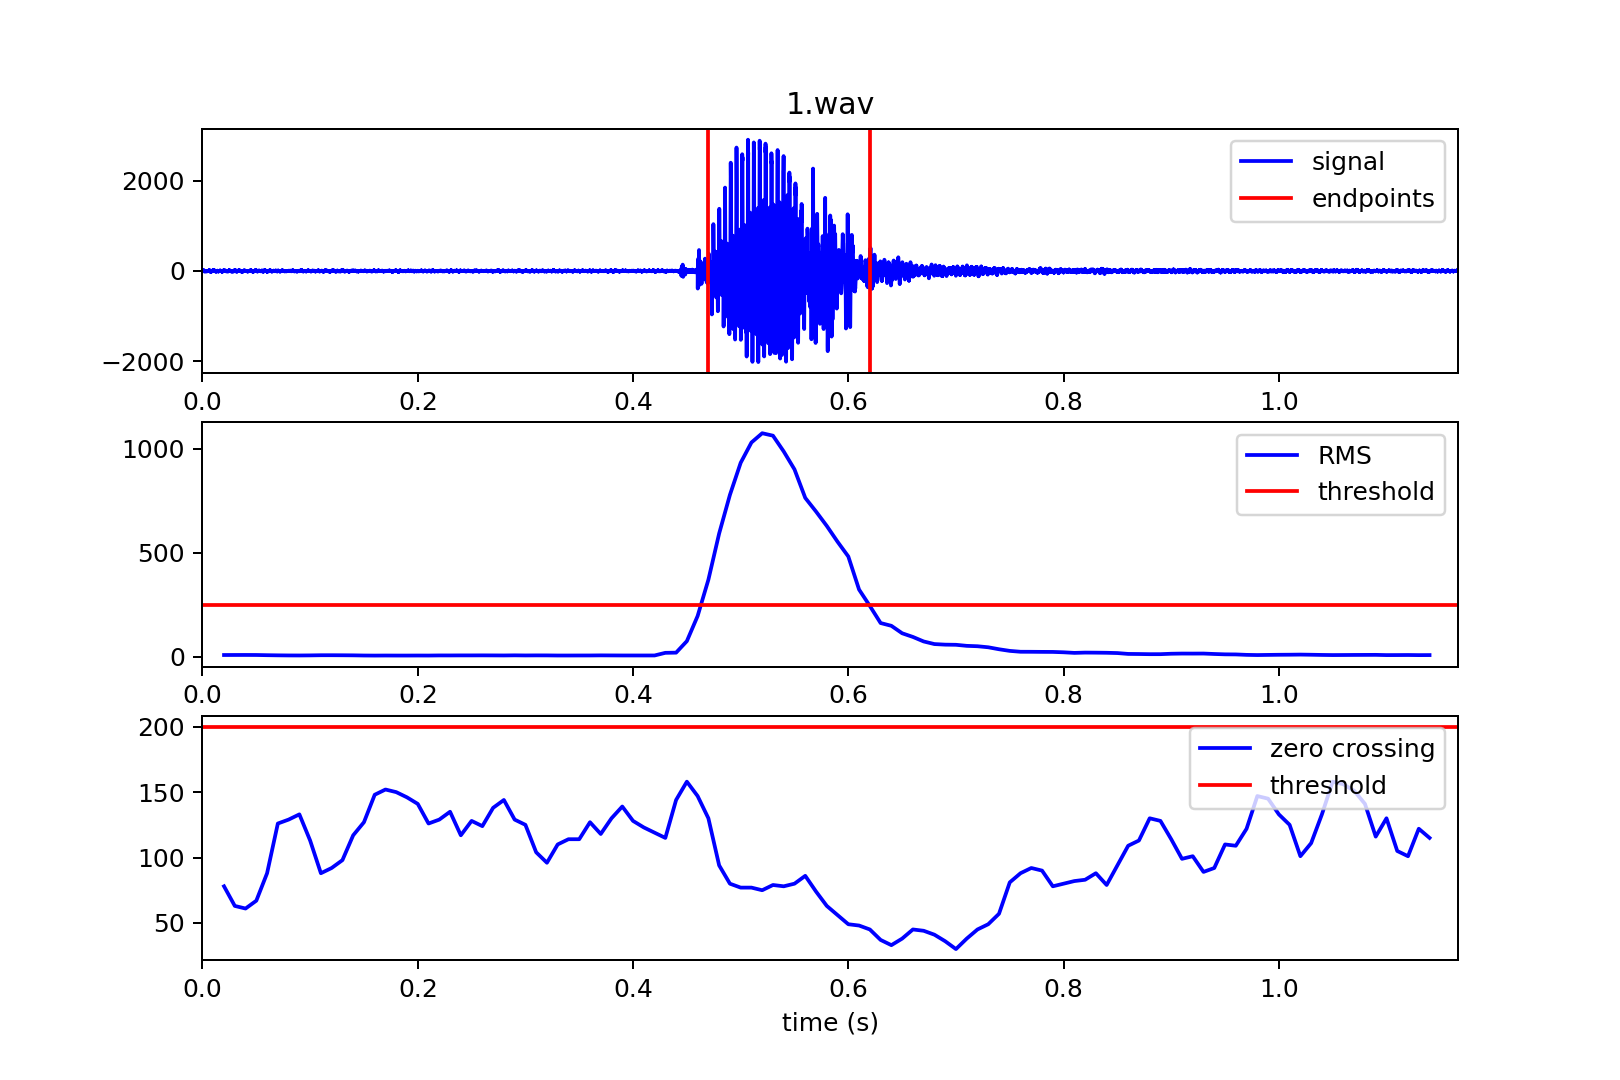

<IPython.core.display.Javascript object>


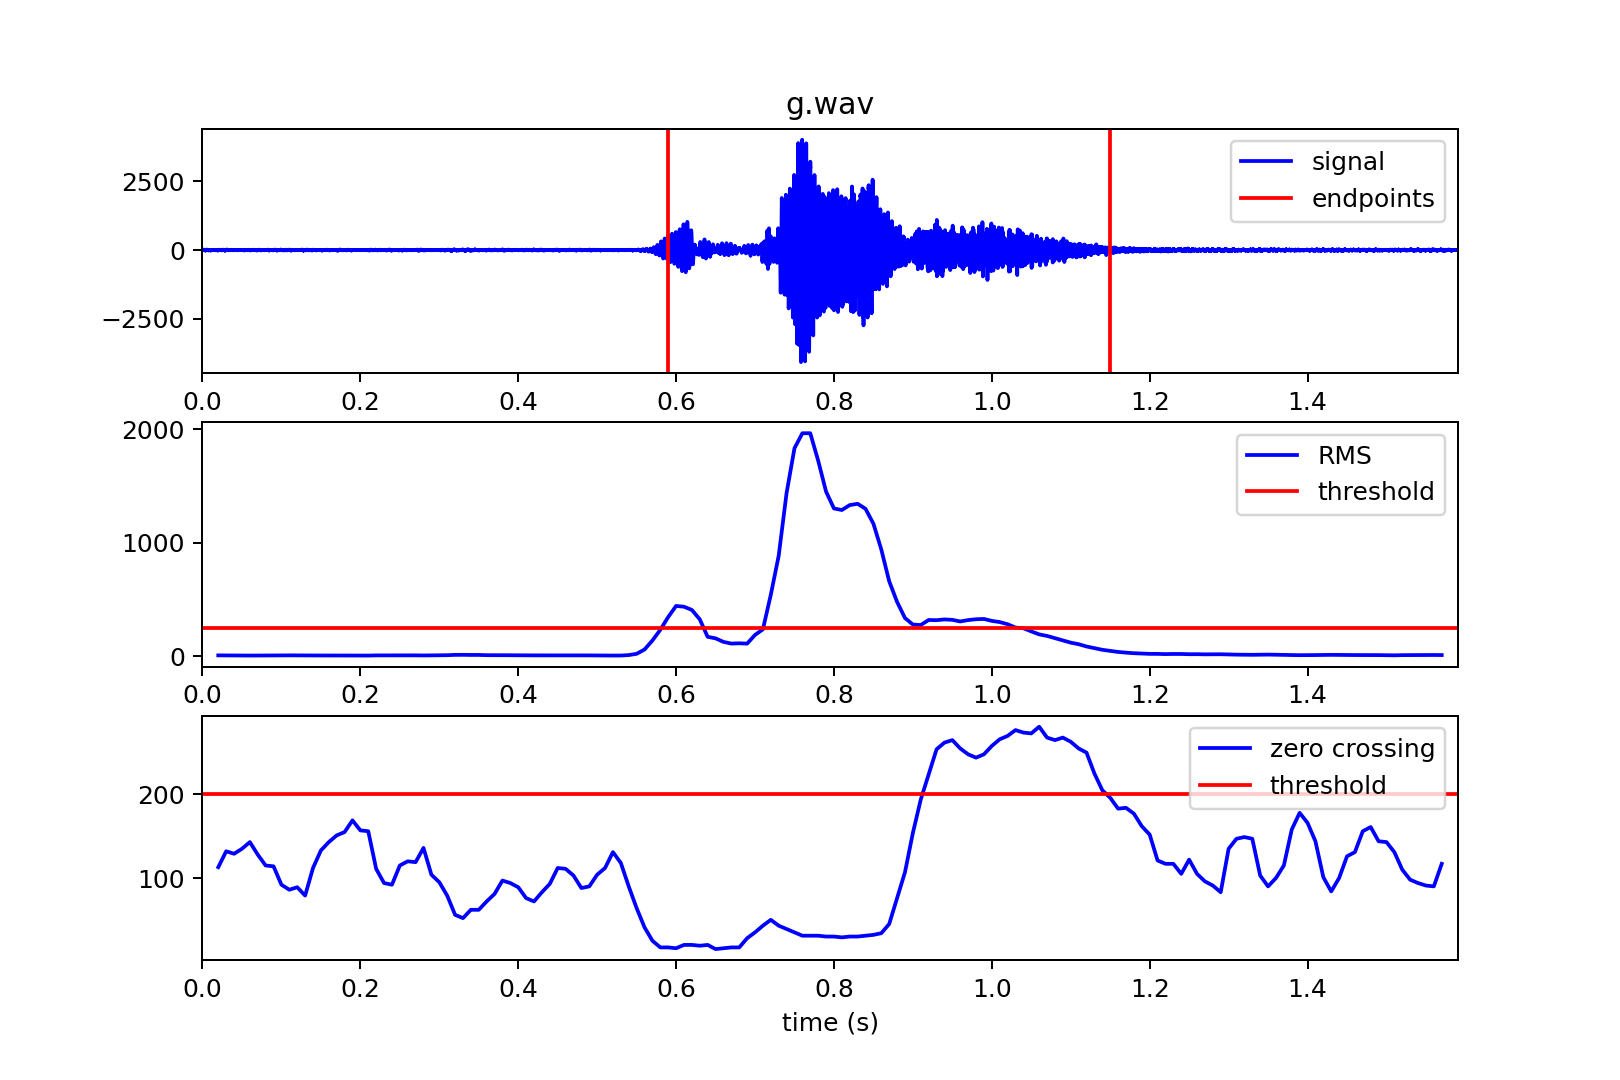

<IPython.core.display.Javascript object>


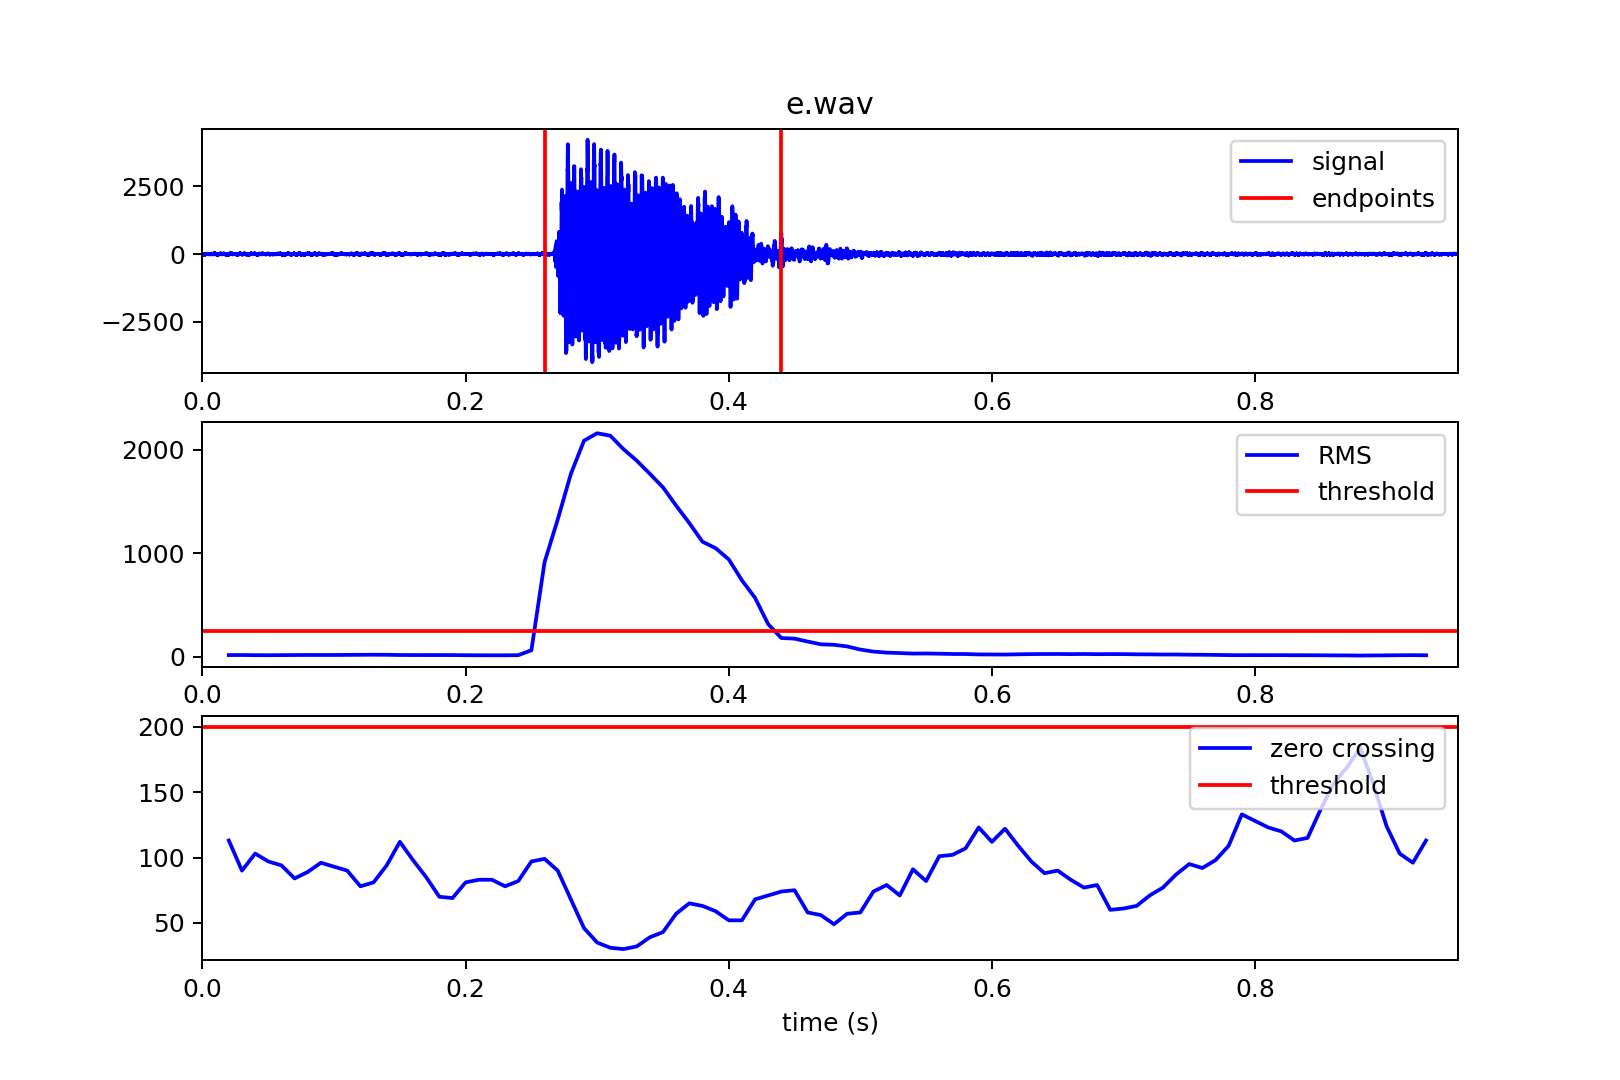

<IPython.core.display.Javascript object>


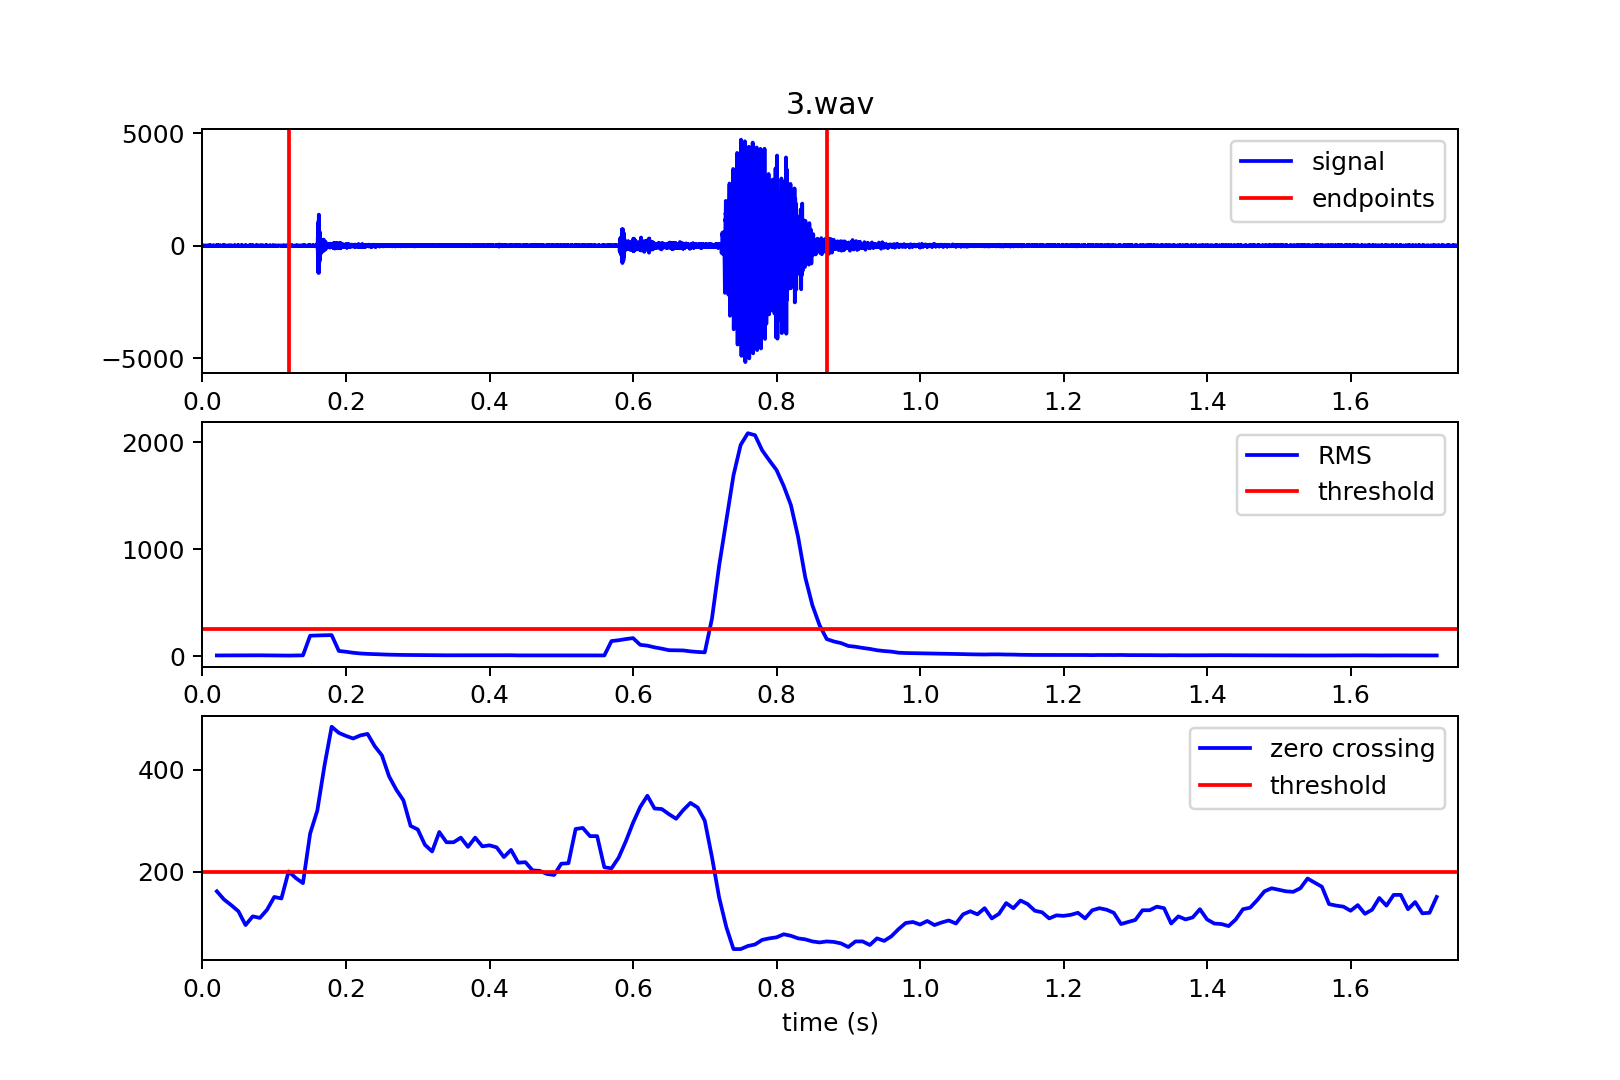

<IPython.core.display.Javascript object>


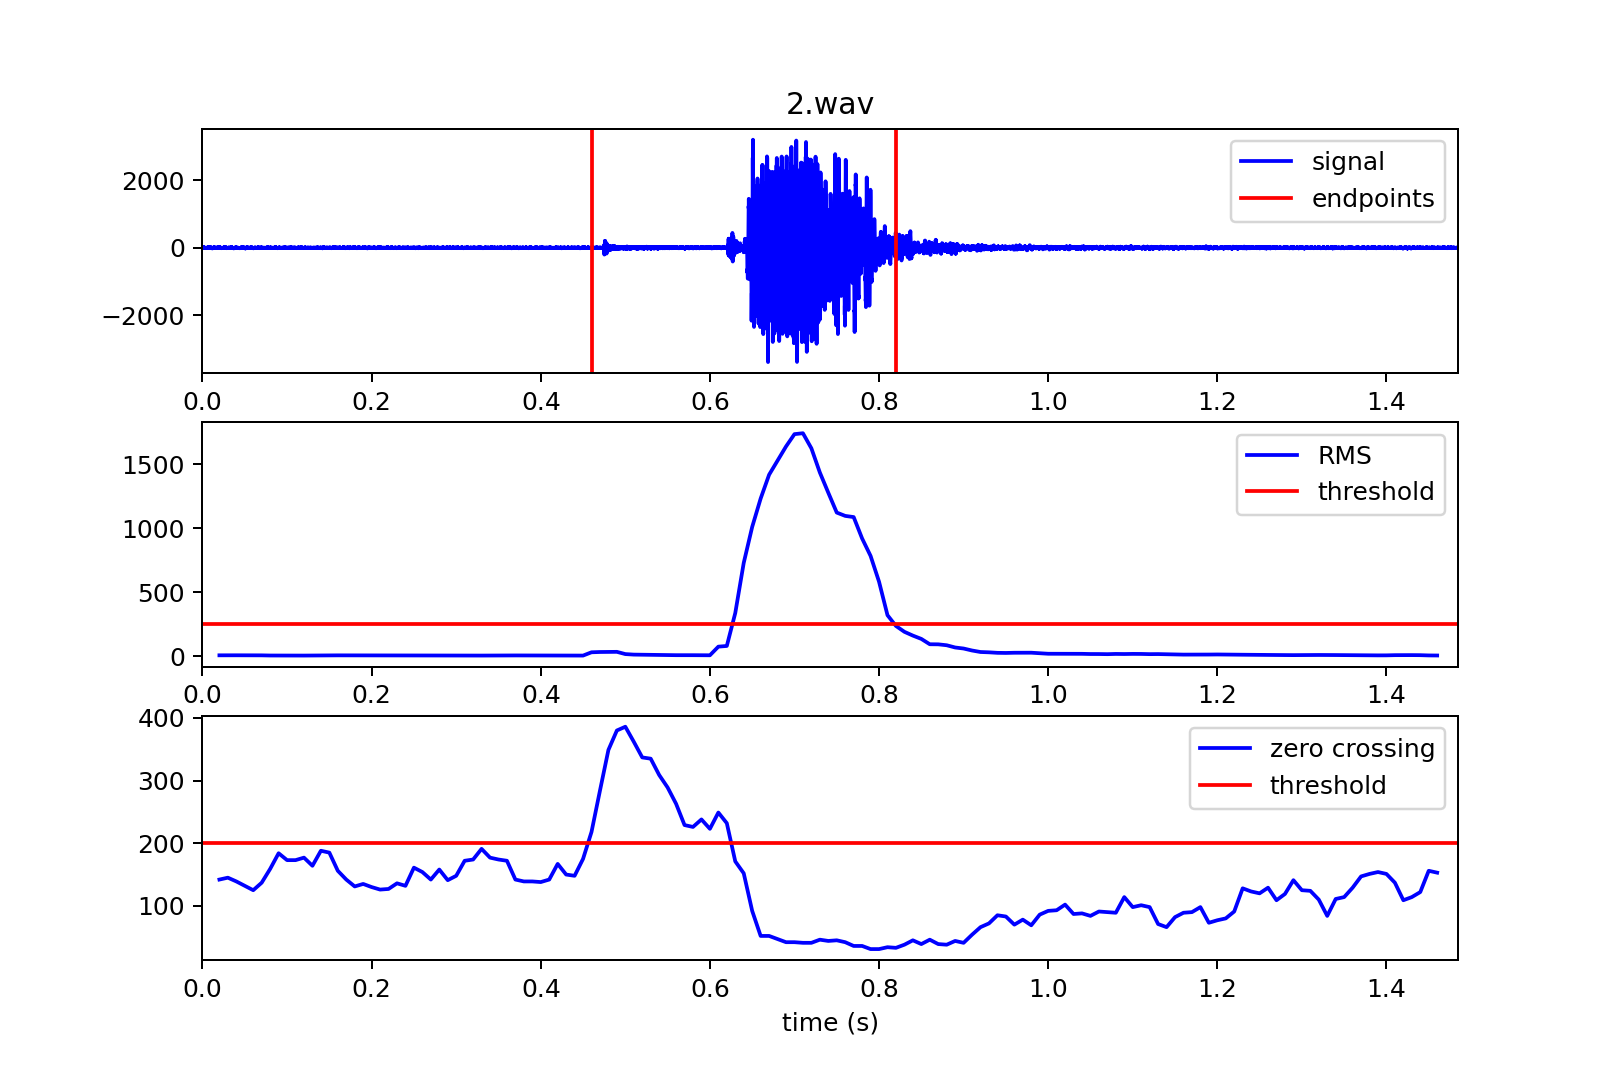

<IPython.core.display.Javascript object>


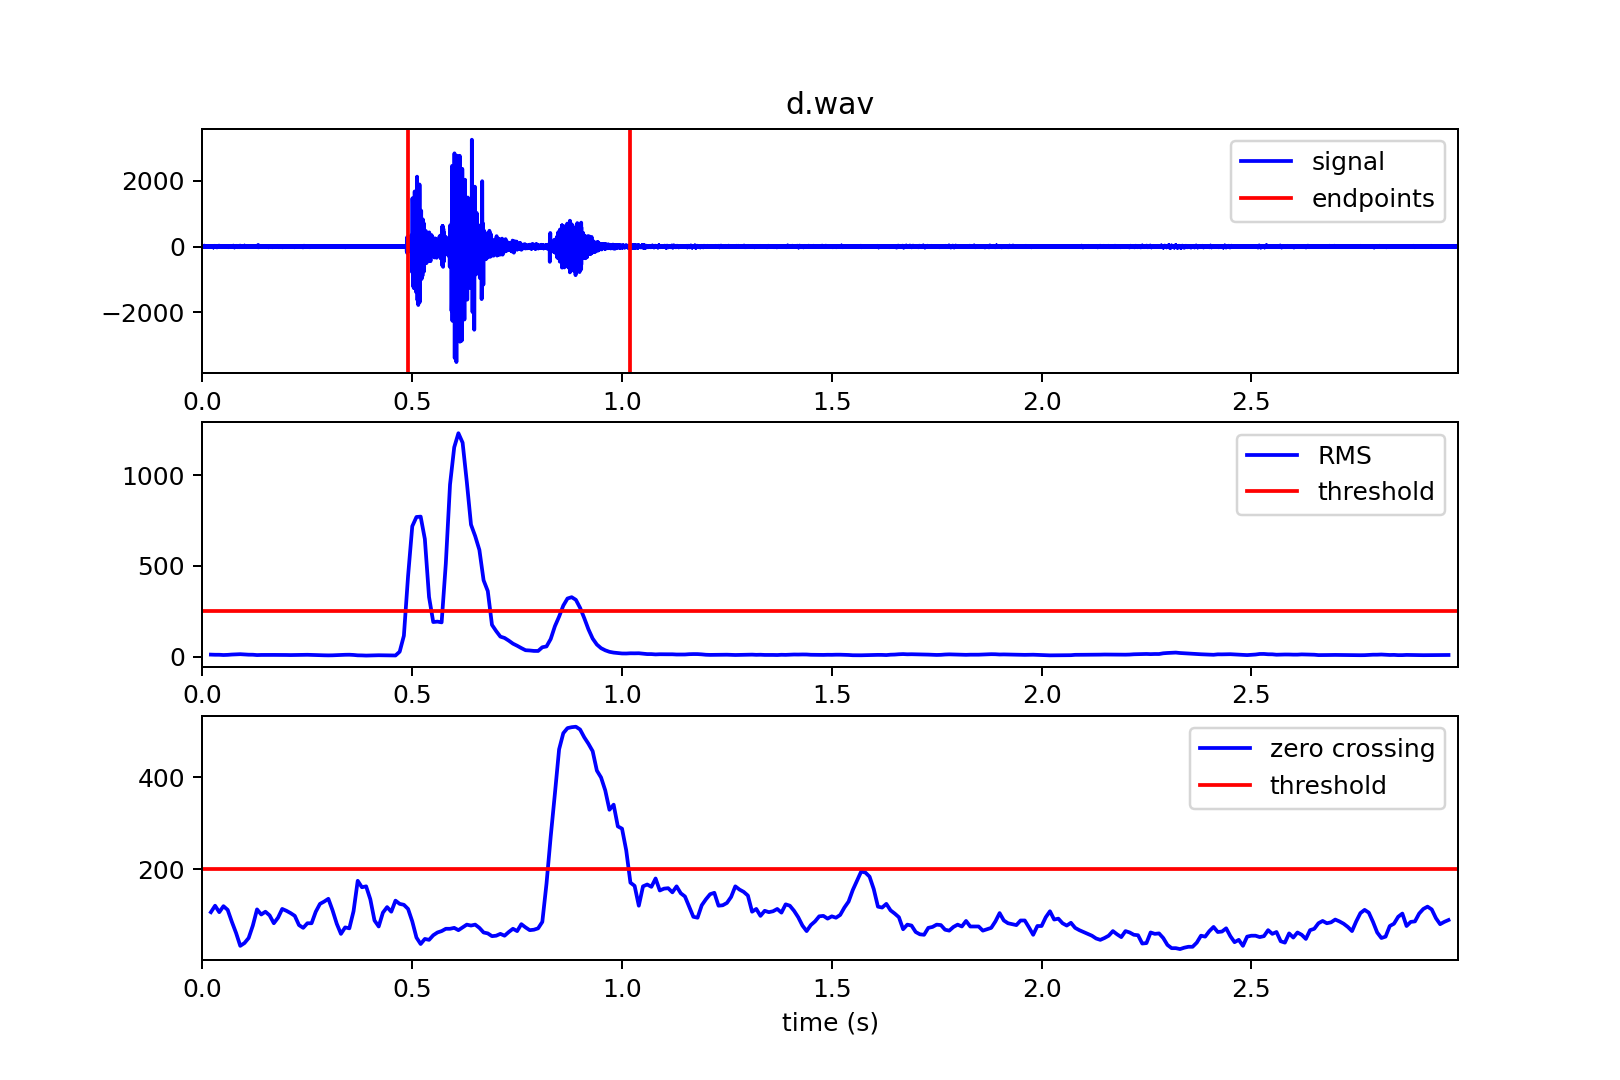

In [35]:

#Test des valeurs des paramètres 
trms = 250 #seuil trms pour savoir qu'un mot est prononcé (juste avec l'analyse des graphes )


tzc = 200 #seuil zcr pour savoir qu'un mot est prononcé 
# Justification : parce que quand j'ai tracer on voit que le bruit et silence sur zero crossing a une amplitude max 
#de 200 environ donc on prends plus. on Laisse une marge on pourrait prendre 250

twmin = 0.0001 #durée pour consideré que c'est un mot nos audio sont très cours donc il faut prendre de m'ordre du ms
tsmax = 1 #seuil pour considerer silence

#Boucle pour tracer 
dossier_mots= "/Users/khadidja/Downloads"
for filename in os.listdir(dossier_mots):
    if filename.endswith(".wav"):
        endpoint_detection(filename, trms, tzc, twmin, tsmax)


<span style="color:blue">
Les paramètres temporels doivent être choisis en fonction de notre signal. Par exemple, le seuil minimal pour considérer qu'un mot est prononcé dépend fortement de la durée de notre enregistrement. En fait, il faut simplement bien analyser les caractéristiques de notre signal afin de pouvoir fixer des seuils qui ne faussent pas les résultats.
</span> 